<a href="https://colab.research.google.com/github/arkinbhagat/Car-Price-Analysis-Project/blob/main/Forecast_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement

Determine what influences car prices given its technical specifications. Find which cars that are the most under/overpriced and justify your reasoning.

# Imports

## Libraries

This section imports python libraries required for some of the functions in the notebook.

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from IPython.display import display
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
np.random.seed(0)

## Car Dataset

Here, I have imported the dataset into a pandas dataframe. A sample record is also shown below.

In [ ]:
cars = pd.read_csv("car_data_cleaned.csv") 
print("Initial Shape of the Dataframe: ", cars.shape)

display(cars.head(1)) 

Initial Shape of the Dataframe:  (11457, 87)


Unnamed: 0                        Car_Make_Model_Style     MSRP  \
0           0  2019 Acura RDX Specs: FWD w/Technology Pkg  40600.0   

             Style Name         Drivetrain  Passenger Capacity  \
0  FWD w/Technology Pkg  Front Wheel Drive                   5   

   Passenger Doors     Body Style                EPA Classification  \
0                4  Sport Utility  Small Sport Utility Vehicles 2WD   

   Base Curb Weight (lbs)  ...  Displacement (L)  Displacement (cc)  \
0                  3790.0  ...               2.0              122.0   

   Rear Tire Width  Front Tire Width  Rear Wheel Size  Front Wheel Size  \
0            235.0             235.0             19.0              19.0   

   Tire Width Ratio  Wheel Size Ratio  Tire Ratio    Year  
0               1.0               1.0         5.0  2019.0  

[1 rows x 87 columns]


# Data Exploration

The car dataset has 11457 rows and 87 columns. 
A few other things come to mind while looking at the data. 

*   First, I noticed there is a lot of data missing from some of the columns. Columns such as "Passenger Volume" have as much as 48.37% entries missing. The following MSNO missingness matrix shows how much missing data is present in each column visually.

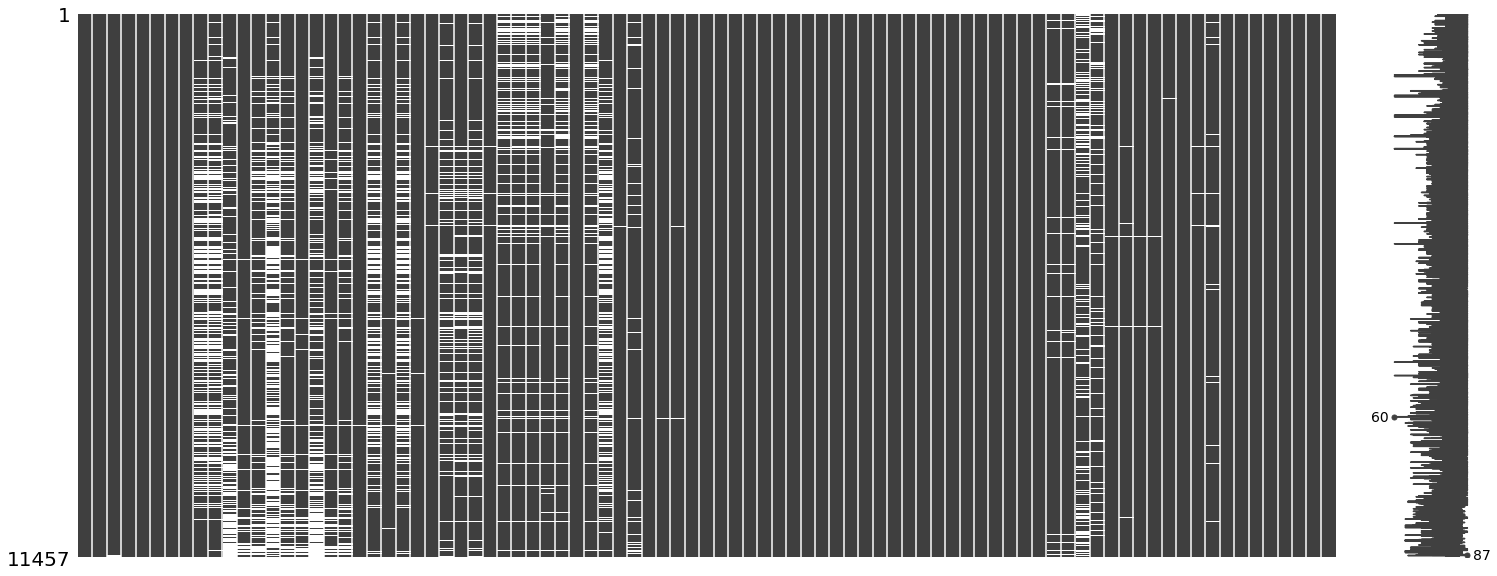

In [ ]:
msno.matrix(cars.sort_values("MSRP"))

The following is a MSNO missingness heatmap that shows the missingness correlation to determine if there is a relationship between the missingness between features. There is no strong negative correlation between the MSRP and the other features, therefore I will not be eliminating any features outright.

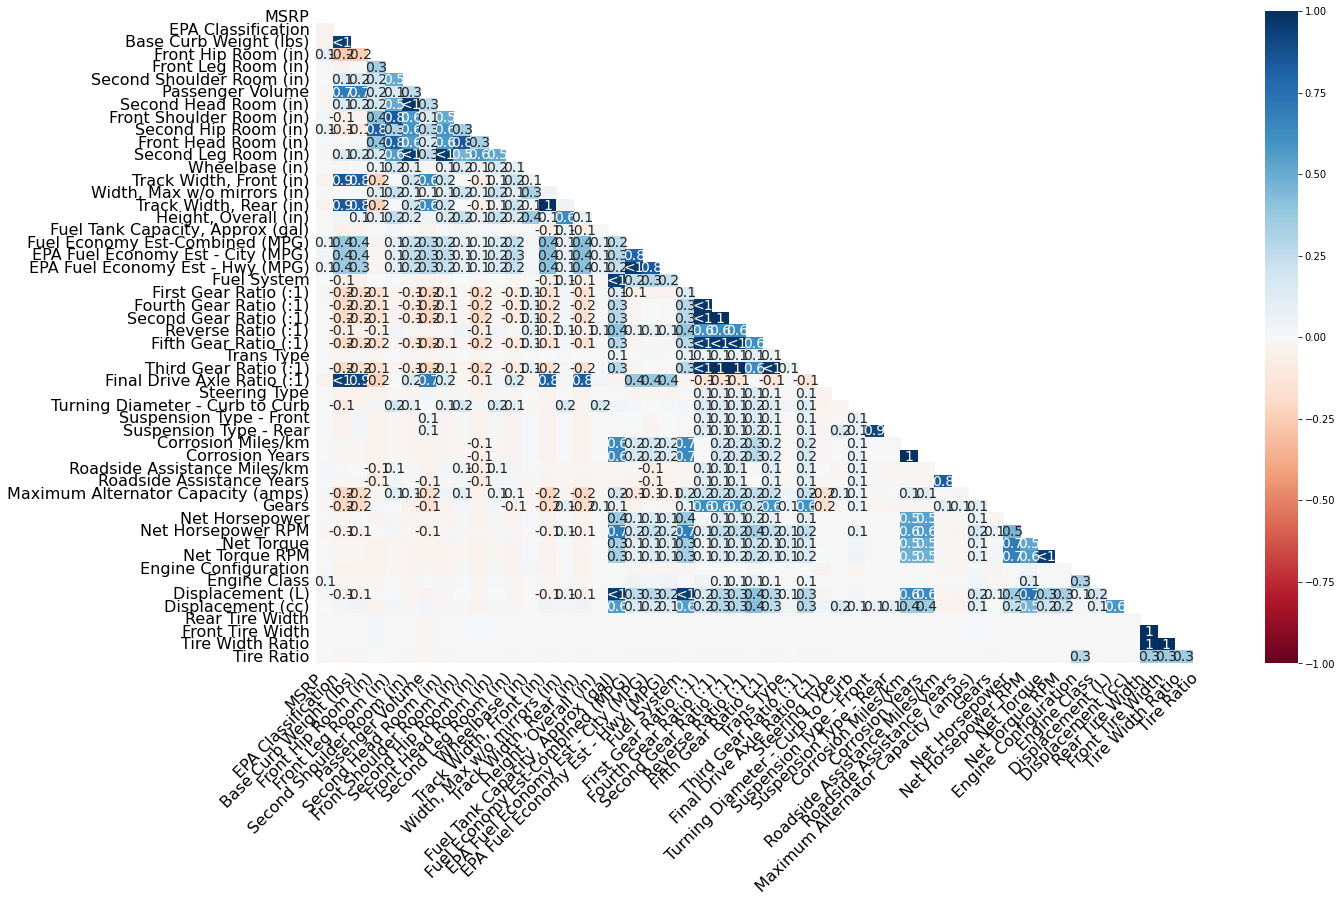

In [ ]:
msno.heatmap(cars)

In [ ]:
print("Missing Values per Column: ", dict(cars.isnull().sum()))
print("Missing Values per Column (as percentages): ", dict(cars.isnull().sum()*100/len(cars)))
print("Highest Percentage of Missing Values: ", max(list(cars.isnull().sum()*100/len(cars))))

Missing Values per Column:  {'Unnamed: 0': 0, 'Car_Make_Model_Style': 0, 'MSRP': 49, 'Style Name': 0, 'Drivetrain': 0, 'Passenger Capacity': 0, 'Passenger Doors': 0, 'Body Style': 0, 'EPA Classification': 3663, 'Base Curb Weight (lbs)': 3941, 'Front Hip Room (in)': 2829, 'Front Leg Room (in)': 565, 'Second Shoulder Room (in)': 1713, 'Passenger Volume': 5542, 'Second Head Room (in)': 1677, 'Front Shoulder Room (in)': 619, 'Second Hip Room (in)': 3744, 'Front Head Room (in)': 617, 'Second Leg Room (in)': 1658, 'Wheelbase (in)': 17, 'Track Width, Front (in)': 3167, 'Width, Max w/o mirrors (in)': 92, 'Track Width, Rear (in)': 3168, 'Height, Overall (in)': 74, 'Fuel Tank Capacity, Approx (gal)': 151, 'Fuel Economy Est-Combined (MPG)': 1876, 'EPA Fuel Economy Est - City (MPG)': 1481, 'EPA Fuel Economy Est - Hwy (MPG)': 1980, 'Fuel System': 145, 'First Gear Ratio (:1)': 1458, 'Fourth Gear Ratio (:1)': 1526, 'Second Gear Ratio (:1)': 1521, 'Reverse Ratio (:1)': 706, 'Fifth Gear Ratio (:1)': 15

*   There are a number of numerical and categorical features for each car. While performing recursive feature elimination later in this notebook, it would be better to separate the two features, because categorical features contain text which causes problems with machine learning models.

*   And finally, the data itself has a few case and spelling errors that should be corrected to avoid unwanted results.



I will now preprocess the data to make it a bit easier to work with.

# Preprocessing

We need to deal with the missing data and do some further processing before we continue any further. Let's begin by checking for any duplicate records.

In [ ]:
cars.loc[cars.duplicated()]

Empty DataFrame
Columns: [Unnamed: 0, Car_Make_Model_Style, MSRP, Style Name, Drivetrain, Passenger Capacity, Passenger Doors, Body Style, EPA Classification, Base Curb Weight (lbs), Front Hip Room (in), Front Leg Room (in), Second Shoulder Room (in), Passenger Volume, Second Head Room (in), Front Shoulder Room (in), Second Hip Room (in), Front Head Room (in), Second Leg Room (in), Wheelbase (in), Track Width, Front (in), Width, Max w/o mirrors (in), Track Width, Rear (in), Height, Overall (in), Fuel Tank Capacity, Approx (gal), Fuel Economy Est-Combined (MPG), EPA Fuel Economy Est - City (MPG), EPA Fuel Economy Est - Hwy (MPG), Fuel System, First Gear Ratio (:1), Fourth Gear Ratio (:1), Second Gear Ratio (:1), Reverse Ratio (:1), Fifth Gear Ratio (:1), Trans Type, Third Gear Ratio (:1), Final Drive Axle Ratio (:1), Steering Type, Turning Diameter - Curb to Curb, Front Wheel Material, Suspension Type - Front, Suspension Type - Rear, Air Bag-Frontal-Driver, Air Bag-Frontal-Passenger, Air Bag-Passenger Switch (On/Off), Air Bag-Side Body-Front, Air Bag-Side Body-Rear, Air Bag-Side Head-Front, Air Bag-Side Head-Rear, Brakes-ABS, Child Safety Rear Door Locks, Daytime Running Lights, Traction Control, Night Vision, Rollover Protection Bars, Fog Lamps, Parking Aid, Tire Pressure Monitor, Back-Up Camera, Stability Control, Other Features, Basic Miles/km, Basic Years, Corrosion Miles/km, Corrosion Years, Drivetrain Miles/km, Drivetrain Years, Roadside Assistance Miles/km, Roadside Assistance Years, Maximum Alternator Capacity (amps), Gears, Net Horsepower, Net Horsepower RPM, Net Torque, Net Torque RPM, Engine Configuration, Engine Class, Displacement (L), Displacement (cc), Rear Tire Width, Front Tire Width, Rear Wheel Size, Front Wheel Size, Tire Width Ratio, Wheel Size Ratio, Tire Ratio, Year]
Index: []

[0 rows x 87 columns]

Since the cars have a column with their make, model and style in one cell, I have extracted the car brands into a separate column called "Make". The reasoning behind this is that there are some high-end car brands in the dataset which can heavily skew the average MSRP in their favour, so it is better to take that into account and it also makes it easier to spot outliers. I have also dropped a redundant index column which is not of any use to the analysis.


In [ ]:
cars_cleaned = cars
cars_cleaned = cars_cleaned.drop('Unnamed: 0', axis=1)
cars_cleaned['Make'] = cars_cleaned['Car_Make_Model_Style'].apply(lambda x : x.split(' ')[1]) # extracts brand names from the 'car_make_model_style' column into a separate column
print(cars_cleaned["Make"].unique())

['Acura' 'Alfa' 'Aston' 'Audi' 'Bentley' 'BMW' 'Buick' 'Cadillac'
 'Chevrolet' 'Chrysler' 'Dodge' 'Ferrari' 'FIAT' 'Ford' 'Genesis' 'GMC'
 'Honda' 'Hyundai' 'INFINITI' 'Jaguar' 'Jeep' 'Kia' 'Lamborghini' 'Land'
 'Lexus' 'Lincoln' 'Lotus' 'Maserati' 'Mazda' 'McLaren' 'Mercedes-Benz'
 'MINI' 'Mitsubishi' 'Nissan' 'Porsche' 'Ram' 'Rolls-Royce' 'smart'
 'Subaru' 'Tesla' 'Toyota' 'Volkswagen' 'Volvo']


There are a few spelling and case errors here and there, which have been corrected to maintain consistency. 

In [ ]:
# this section corrects various spelling and case errors which may cause difficulties in the anaylsis later on

cars_cleaned["Make"] = cars_cleaned["Make"].replace({'Alfa': 'Alfa Romeo'})
cars_cleaned["Make"] = cars_cleaned["Make"].replace({'Aston': 'Aston Martin'})
cars_cleaned["Make"] = cars_cleaned["Make"].replace({'Land': 'Land Rover'})
cars_cleaned["Drivetrain"] = cars_cleaned["Drivetrain"].replace({'Rear wheel drive': 'Rear Wheel Drive'})
cars_cleaned["Fuel System"] = cars_cleaned["Fuel System"].replace({'Electronic fuel injection': 'Electronic Fuel Injection'})
cars_cleaned["Fuel System"] = cars_cleaned["Fuel System"].replace({'Sequential MPI (injection)': 'Sequential MPI'})
cars_cleaned["Fuel System"] = cars_cleaned["Fuel System"].replace({'DI': 'Direct Injection'})
cars_cleaned["Engine Configuration"] = cars_cleaned["Engine Configuration"].replace({'l': 'I'})
cars_cleaned["EPA Classification"] = cars_cleaned["EPA Classification"].replace({'Compact Car': 'Compact Cars'})
cars_cleaned = cars_cleaned.replace({'Yes': 1})
cars_cleaned = cars_cleaned.replace({'No': 0})
print(cars_cleaned["Make"].unique())

['Acura' 'Alfa Romeo' 'Aston Martin' 'Audi' 'Bentley' 'BMW' 'Buick'
 'Cadillac' 'Chevrolet' 'Chrysler' 'Dodge' 'Ferrari' 'FIAT' 'Ford'
 'Genesis' 'GMC' 'Honda' 'Hyundai' 'INFINITI' 'Jaguar' 'Jeep' 'Kia'
 'Lamborghini' 'Land Rover' 'Lexus' 'Lincoln' 'Lotus' 'Maserati' 'Mazda'
 'McLaren' 'Mercedes-Benz' 'MINI' 'Mitsubishi' 'Nissan' 'Porsche' 'Ram'
 'Rolls-Royce' 'smart' 'Subaru' 'Tesla' 'Toyota' 'Volkswagen' 'Volvo']


For the columns containing missing data, I have imputed the values using a K-Nearest Neighbours Imputer for numerical features, and the respective column's mode for the categorical features, since imputation with mean or median can not be performed on strings or objects. The K-Nearest Neighbours imputer takes the mean of the 'K' closest neighbours of the missing value.

In [ ]:
imputer = KNNImputer(n_neighbors=5) # KNN imputer from the sklearn library that replaces missing values using 5 nearest neighbours
cars_cleaned = cars_cleaned.copy() # to avoid the "SettingWithCopyWarning" error

for column in cars_cleaned:
  if cars_cleaned[column].dtype == np.dtype('O'): # if the datatype of the column is of string type, impute missing values with the mode
    cars_cleaned.loc[:, column].fillna(cars_cleaned[column].value_counts().index[0], inplace=True)
  else: # else if the datatype of the column is of numeric type, impute missing values with the KNN imputer
    cars_cleaned.loc[:, column] = imputer.fit_transform(cars_cleaned[[column]]) 

print(cars_cleaned.shape)    

(11457, 87)


# Visual Analysis of MSRP

Now that we can work with the cleaned dataset, let's have a look at some numerical figures to give us an idea of what we're working with.
We can see various statistics like the mean, standard deviation, maximum and minimum values and count for each feature that has numerical features. 



In [ ]:
cars_cleaned.describe() # gives various statistics about the dataset 

MSRP  Passenger Capacity  Passenger Doors  \
count   11457.000000        11457.000000     11457.000000   
mean    46757.176893            5.038841         3.615344   
std     39893.042363            1.458029         0.765427   
min     11990.000000            1.000000         2.000000   
25%     29195.000000            5.000000         4.000000   
50%     37500.000000            5.000000         4.000000   
75%     49100.000000            5.000000         4.000000   
max    548800.000000           15.000000         4.000000   

       Base Curb Weight (lbs)  Front Hip Room (in)  Front Leg Room (in)  \
count            11457.000000         11457.000000         11457.000000   
mean              3689.308010            56.967216            42.212651   
std                519.893122             3.596313             1.531789   
min               1808.000000            45.400000            35.800000   
25%               3465.000000            54.700000            41.200000   
50%               3689.308010            56.967216            42.000000   
75%               3871.000000            58.400000            42.800000   
max               8591.000000            67.600000            63.900000   

       Second Shoulder Room (in)  Passenger Volume  Second Head Room (in)  \
count               11457.000000      11457.000000            11457.00000   
mean                   57.461615        102.257481               38.30944   
std                     4.795672         15.960927                1.61552   
min                    39.700000         44.000000               31.00000   
25%                    55.000000         98.200000               37.50000   
50%                    57.000000        102.257481               38.30944   
75%                    58.900000        102.257481               39.10000   
max                    71.400000        172.600000               65.20000   

       Front Shoulder Room (in)  ...  Displacement (L)  Displacement (cc)  \
count              11457.000000  ...      11457.000000       11457.000000   
mean                  59.193844  ...          2.999204         203.254220   
std                    4.433940  ...          1.387953          84.502495   
min                   40.900000  ...          1.000000          55.000000   
25%                   56.100000  ...          2.000000         122.000000   
50%                   57.900000  ...          3.000000         203.254220   
75%                   62.000000  ...          4.000000         241.000000   
max                   74.800000  ...          7.000000         427.000000   

       Rear Tire Width  Front Tire Width  Rear Wheel Size  Front Wheel Size  \
count     11457.000000      11457.000000     11457.000000      11457.000000   
mean        243.477654        239.910091        17.895697         17.881295   
std          27.037196         23.467534         1.419031          1.404196   
min         155.000000        155.000000        14.000000         14.000000   
25%         225.000000        225.000000        17.000000         17.000000   
50%         245.000000        245.000000        18.000000         18.000000   
75%         265.000000        255.000000        19.000000         19.000000   
max         355.000000        325.000000        22.000000         22.000000   

       Tire Width Ratio  Wheel Size Ratio    Tire Ratio          Year  
count      11457.000000      11457.000000  11457.000000  11457.000000  
mean           1.014541          1.000765      5.254695   2016.610806  
std            0.045981          0.006333      1.164136      1.833207  
min            1.000000          1.000000      3.000000   2014.000000  
25%            1.000000          1.000000      4.000000   2015.000000  
50%            1.000000          1.000000      5.000000   2016.000000  
75%            1.000000          1.000000      6.000000   2018.000000  
max            1.392157          1.058824      8.000000   2019.000000  

[8 rows x 72 columns]

Looking at our target feature (MSRP), we can see it ranges from 11990 to 548800 with a mean of 46757.176893 and a standard deviation of 39893.042363. The median is 37500, which means there is quite a significant difference between the mean and the median of the MSRP distribution. Let's plot some graphs to make all this information easier to comprehend.

## MSRP Distribution and Spread

As shown below, we have a right-skewed distribution, where most car MSRPs (about 75%) are below 49,100. There is a high variance in the  MSRP distribution. The data points are spread far across the mean due to the presence of outliers. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


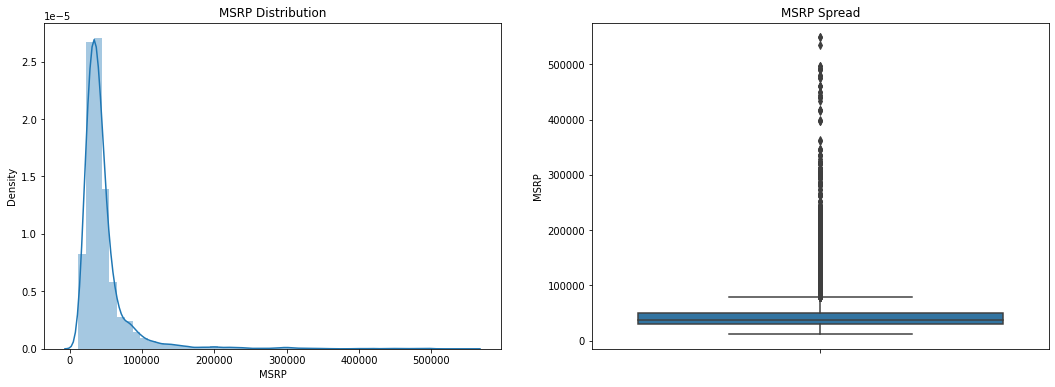

In [ ]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title('MSRP Distribution')
ax = sns.distplot(cars_cleaned["MSRP"]) # plots a univariate distribution of the car MSRPs
plt.subplot(1,2,2)
plt.title('MSRP Spread')
sns.boxplot(y=cars_cleaned["MSRP"]) # plots a box plot of the car MSRps to show the spread of values
plt.show()

# Visual Analysis of Categorical Features

Since categorical features can not be represented in a correlation heatmap, I will first analyse the categorical features with distribution, spread and average MSRP plots.

## Cars by Brand

The most popular car brands according to the data are: Ford, Chevrolet and Toyota. High-end cars such as Lamborghini, Rolls-Royce and Bentley are not as popular, but have high MSRP ranges. One can also note that such cars have the highest MSRP ranges as observed in the box plot.

Some mid-range cars also have outliers that lie above the MSRP ranges of most low-end cars.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 <a list of 43 Text major ticklabel objects>)

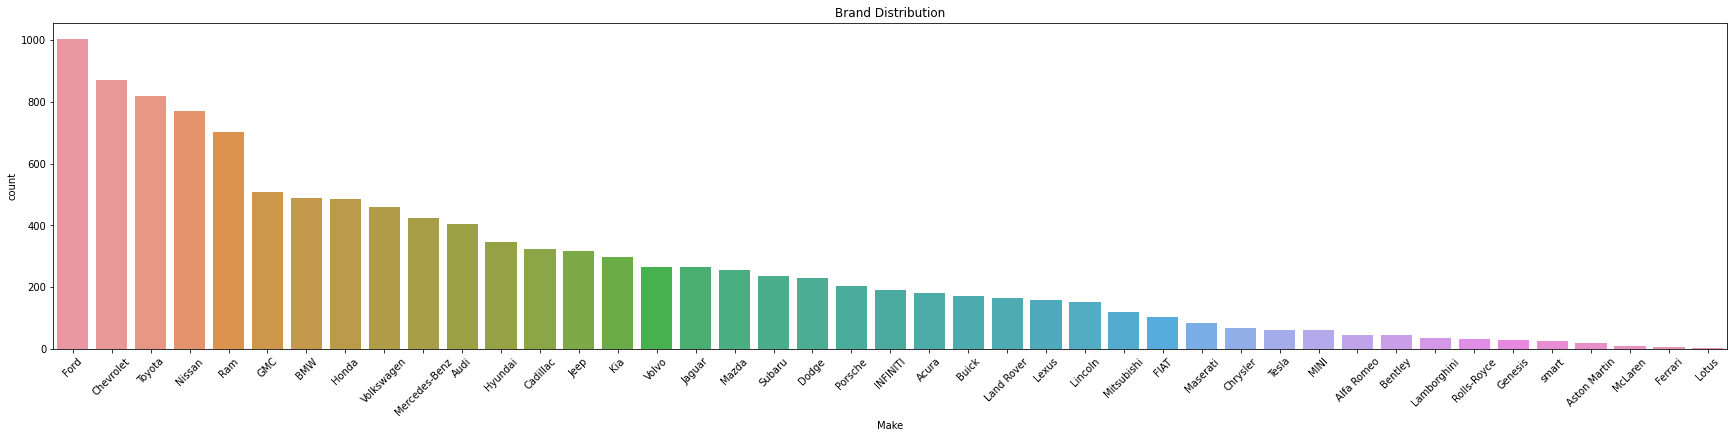

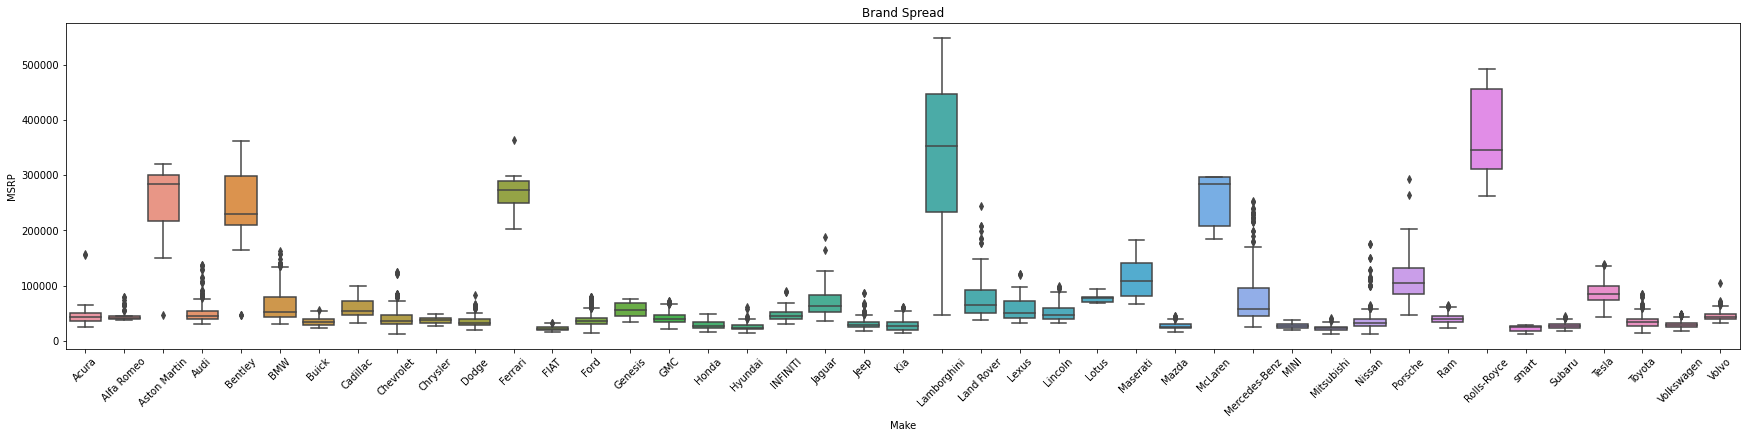

In [ ]:
plt.figure(figsize=(30,6))
plt.title('Brand Distribution')
sns.countplot(data=cars_cleaned, x='Make', order=cars_cleaned['Make'].value_counts().index)
plt.xticks(rotation=45)

plt.figure(figsize=(30,6))
plt.title('Brand Spread')
sns.boxplot(data=cars_cleaned, x='Make', y='MSRP')
plt.xticks(rotation=45)

Luxury and sports car brands such as Rolls-Royce, Lamborghini and Ferrari have the highest average MSRPs by a significantly large margin, whereas low-end brands such as Mitsubishi, Smart and FIA have low average MSRPs.

Text(0.5, 1.0, 'Brand vs Average MSRP')

<Figure size 2160x432 with 0 Axes>

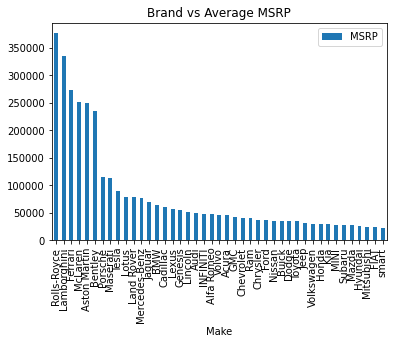

In [ ]:
plt.figure(figsize=(30, 6))
df = pd.DataFrame(cars_cleaned.groupby(['Make'])['MSRP'].mean().sort_values(ascending = False)) # groups cars by their brand and shows the average MSRP for each brand 
df.plot.bar()
plt.title('Brand vs Average MSRP')

## Cars by Fuel System

Gasoline Direct Injection is the the most popular fuel system, followed closely by Sequential MPI. All other fuel systems have considerably fewer cars. 

It can be observed that Gasoline Direct Injection, Sequential MPI and Direct Injection affect the average MSRP the most since they have high counts and a high number of outliers.

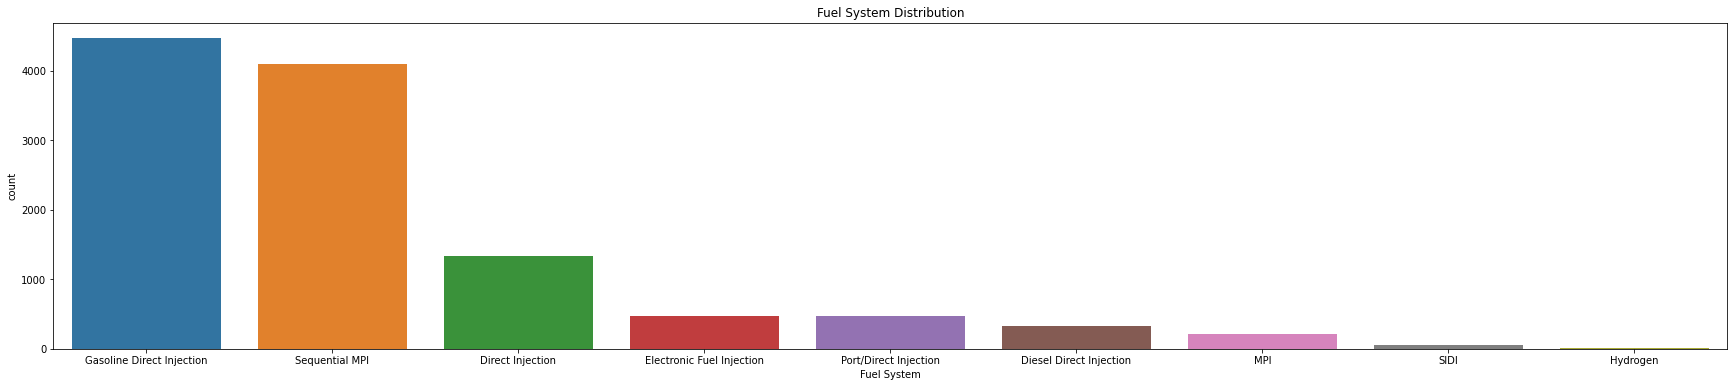

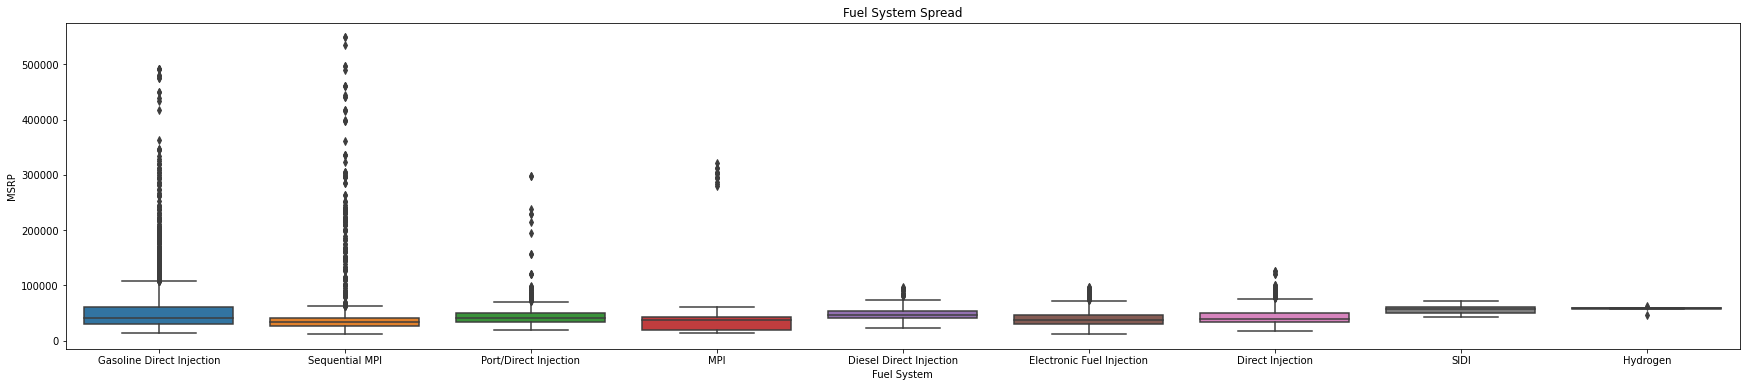

In [ ]:
plt.figure(figsize=(30,6))
plt.title('Fuel System Distribution')
sns.countplot(data=cars_cleaned, x='Fuel System', order=cars_cleaned['Fuel System'].value_counts().index)

plt.figure(figsize=(30,6))
plt.title('Fuel System Spread')
sns.boxplot(data=cars_cleaned, x='Fuel System', y='MSRP')

Sequential MPI and Electric Fuel Injection cars are the cheapest, however the more expensive fuel systems are not far off in terms of average MSRP.

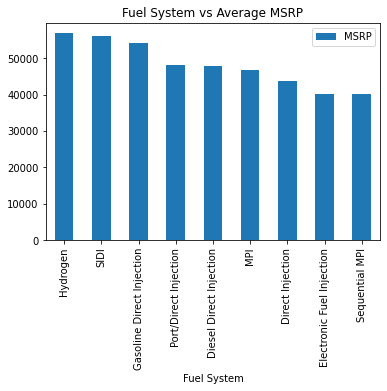

In [ ]:
df = pd.DataFrame(cars_cleaned.groupby(['Fuel System'])['MSRP'].mean().sort_values(ascending = False)) # groups cars by fuel systems and shows the average MSRP for kind of fuel system
df.plot.bar()
plt.title('Fuel System vs Average MSRP')
plt.show()

## Cars by Body Style

Four-door cars are the most popular, followed closely by sports utility cars. Convertibles and two-door cars have the highest MSRP ranges. It can be observed that these four styles have a high number of outliers which can affect the average MSRP.

The other categories have considerably fewer cars. 



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]), <a list of 21 Text major ticklabel objects>)

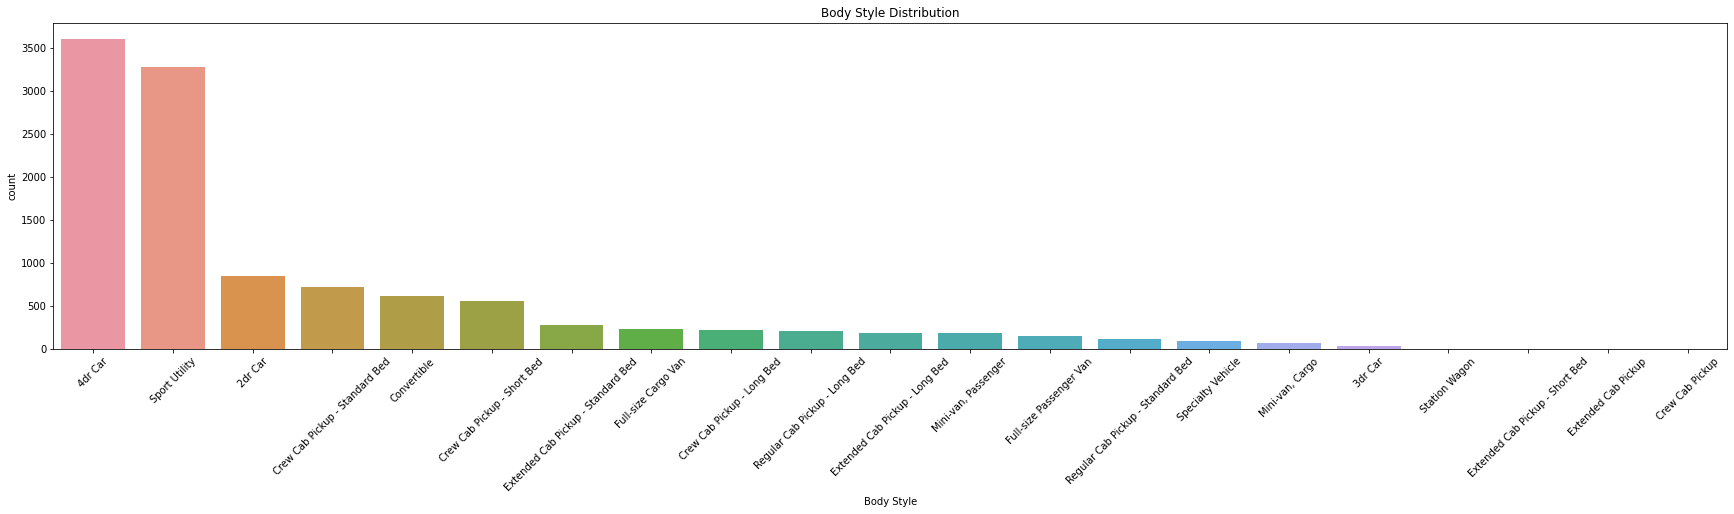

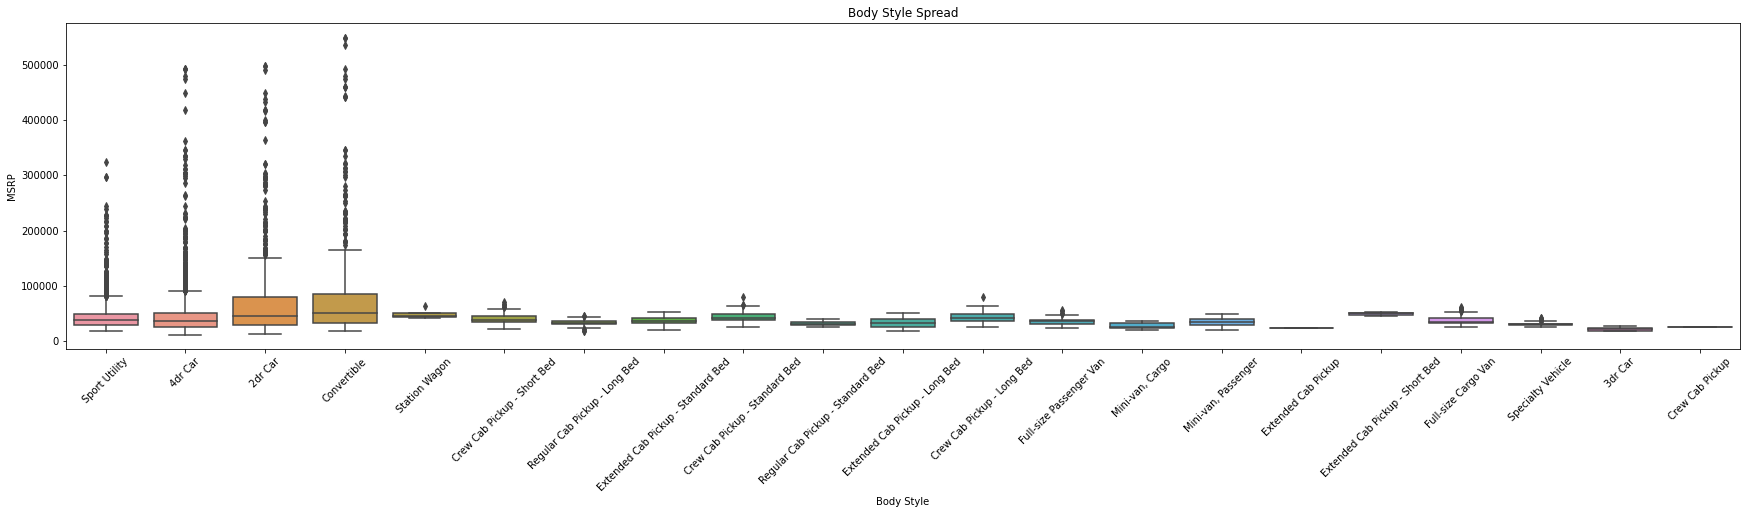

In [ ]:
plt.figure(figsize=(30,6))
plt.title('Body Style Distribution')
sns.countplot(data=cars_cleaned, x='Body Style', order=cars_cleaned['Body Style'].value_counts().index)
plt.xticks(rotation=45)

plt.figure(figsize=(30,6))
plt.title('Body Style Spread')
sns.boxplot(data=cars_cleaned, x='Body Style', y='MSRP')
plt.xticks(rotation=45)

Convertibles and 2-door cars are noticably more expensive than other cars. This could be due to the fact that a lot of luxury and sports cars fall into these two categories.

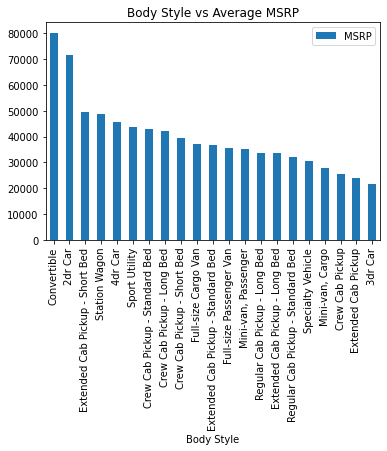

In [ ]:
df = pd.DataFrame(cars_cleaned.groupby(['Body Style'])['MSRP'].mean().sort_values(ascending = False)) # groups cars by their body style and shows the average MSRP for each style
df.plot.bar()
plt.title('Body Style vs Average MSRP')
plt.show()

## Cars by Drivetrain

Front Wheel Drive cars are clearly the most popular, however Rear Wheel Drive, All Wheel Drive and Four Wheel Drive cars have comparable numbers as well. 

The box plots show that Rear Wheel Drive, All Wheel Drive and Four Wheel Drive cars have a high number of outliers and are likely to affect the average MSRPs.

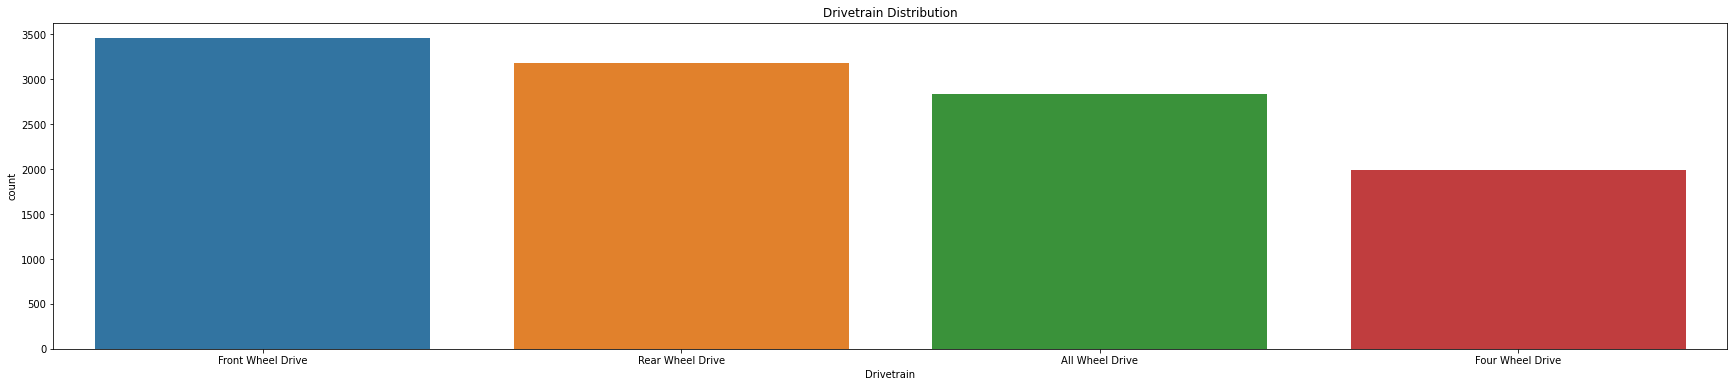

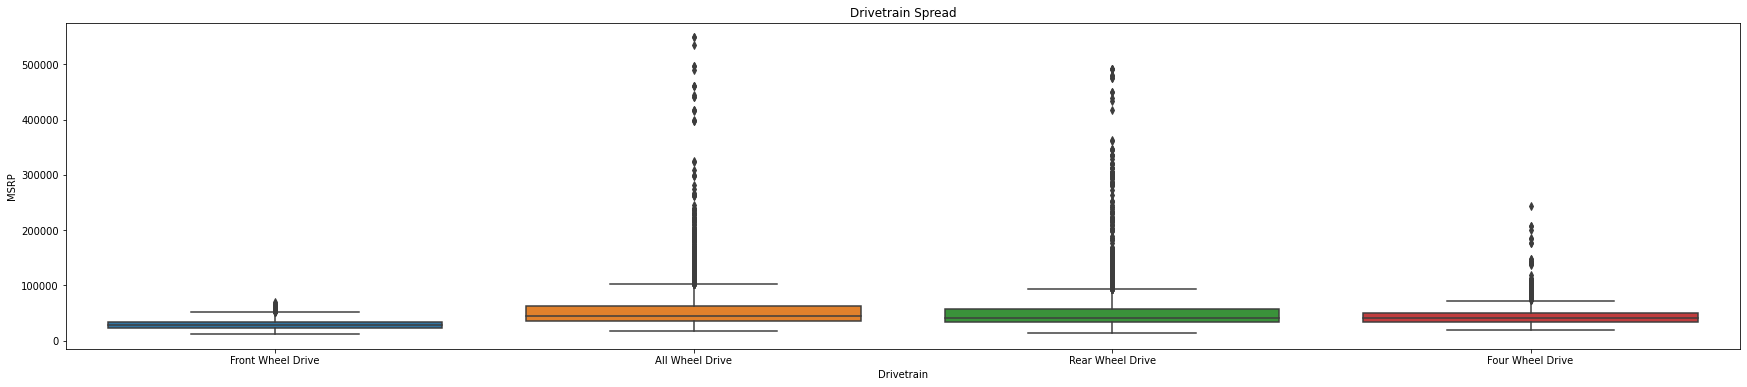

In [ ]:
plt.figure(figsize=(30,6))
plt.title('Drivetrain Distribution')
sns.countplot(data=cars_cleaned, x='Drivetrain', order=cars_cleaned['Drivetrain'].value_counts().index)

plt.figure(figsize=(30,6))
plt.title('Drivetrain Spread')
sns.boxplot(data=cars_cleaned, x='Drivetrain', y='MSRP')

Front Wheel Drive cars are the cheapest amongst the four. All Wheel Drive and Rear Wheel Drive cars have almost double the average MSRP of Front Wheel Drive cars.

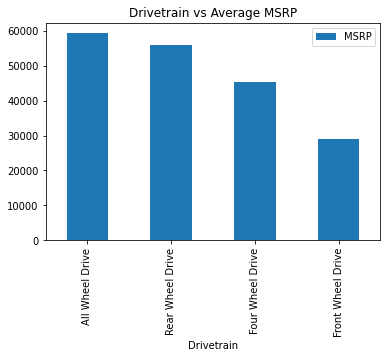

In [ ]:
df = pd.DataFrame(cars_cleaned.groupby(['Drivetrain'])['MSRP'].mean().sort_values(ascending = False)) # groups cars by drivetrains and shows the average MSRP for each drivetrain
df.plot.bar()
plt.title('Drivetrain vs Average MSRP')
plt.show()

## Cars by Engine Class

Cars with Regular engines are the most purchased. There is a sharp decrease from Regular to Intercooled and from Intercooled to Gas.

Twin and electric engine cars have higher MSRP ranges than the rest. The premium category has a very high number of outliers. These three categories are likely to affect the average MSRPs.

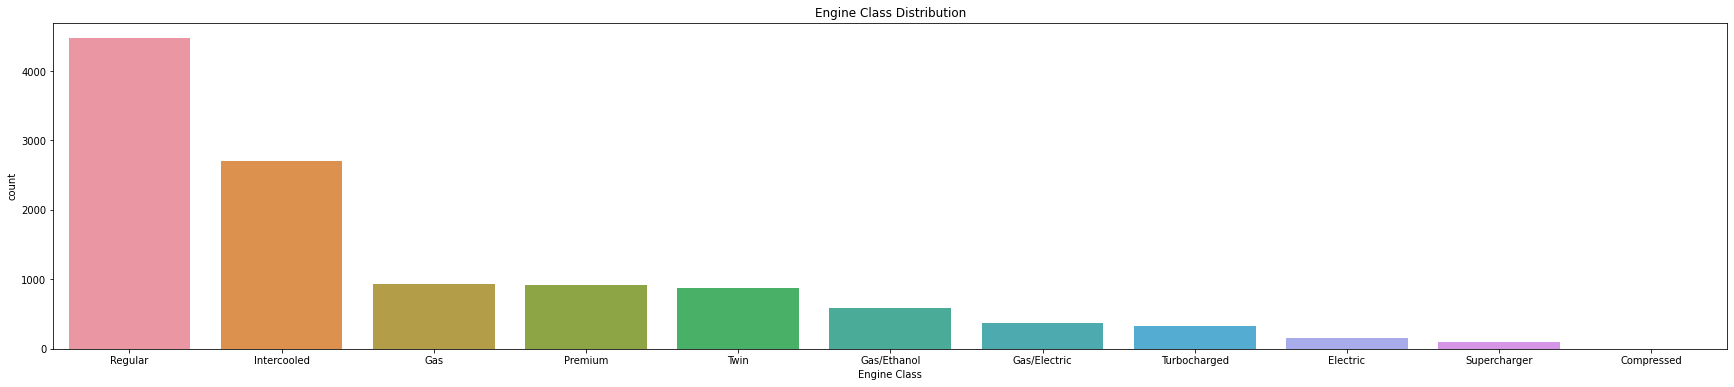

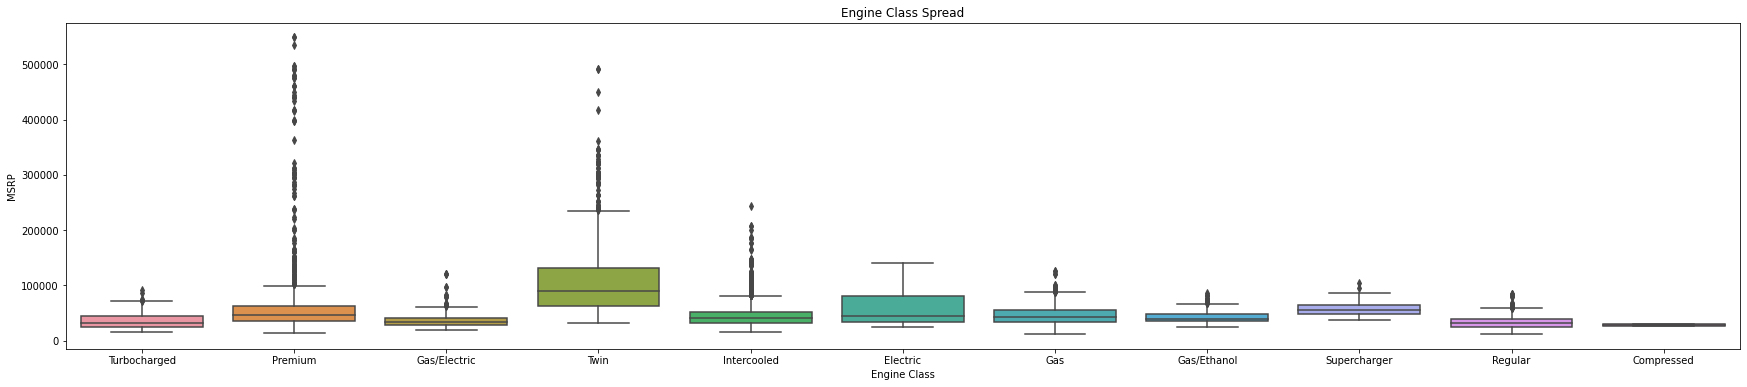

In [ ]:
plt.figure(figsize=(30,6))
plt.title('Engine Class Distribution')
sns.countplot(data=cars_cleaned, x='Engine Class', order=cars_cleaned['Engine Class'].value_counts().index)

plt.figure(figsize=(30,6))
plt.title('Engine Class Spread')
sns.boxplot(data=cars_cleaned, x='Engine Class', y='MSRP')

Twin engines stand out as the most expensive engines going beyond 100,000 average MSRP. Regular and Compressed engines have the lowest average MSRP.

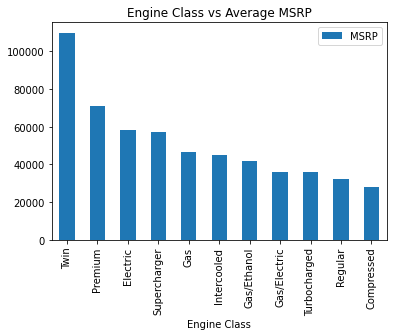

In [ ]:
df = pd.DataFrame(cars_cleaned.groupby(['Engine Class'])['MSRP'].mean().sort_values(ascending = False)) # groups cars by engine classes and shows the average MSRP for each class
df.plot.bar()
plt.title('Engine Class vs Average MSRP')
plt.show()

## Cars by Steering Type

Rack Pinion is by far the most popular steering type. It also has a very high number of outliers meaning it has an effect on the average MSRP.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text major ticklabel objects>)

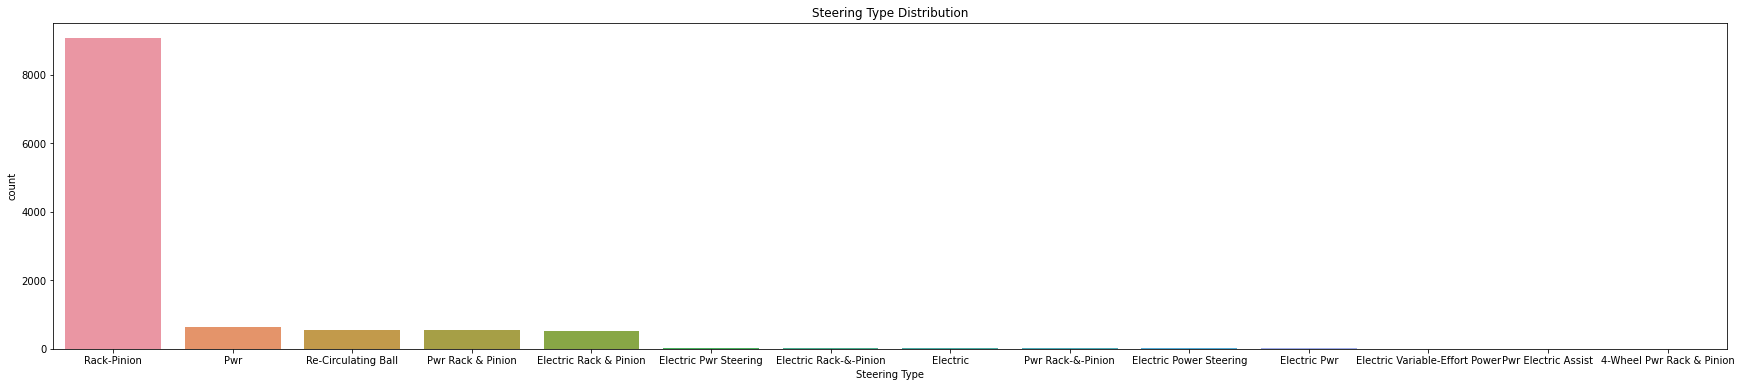

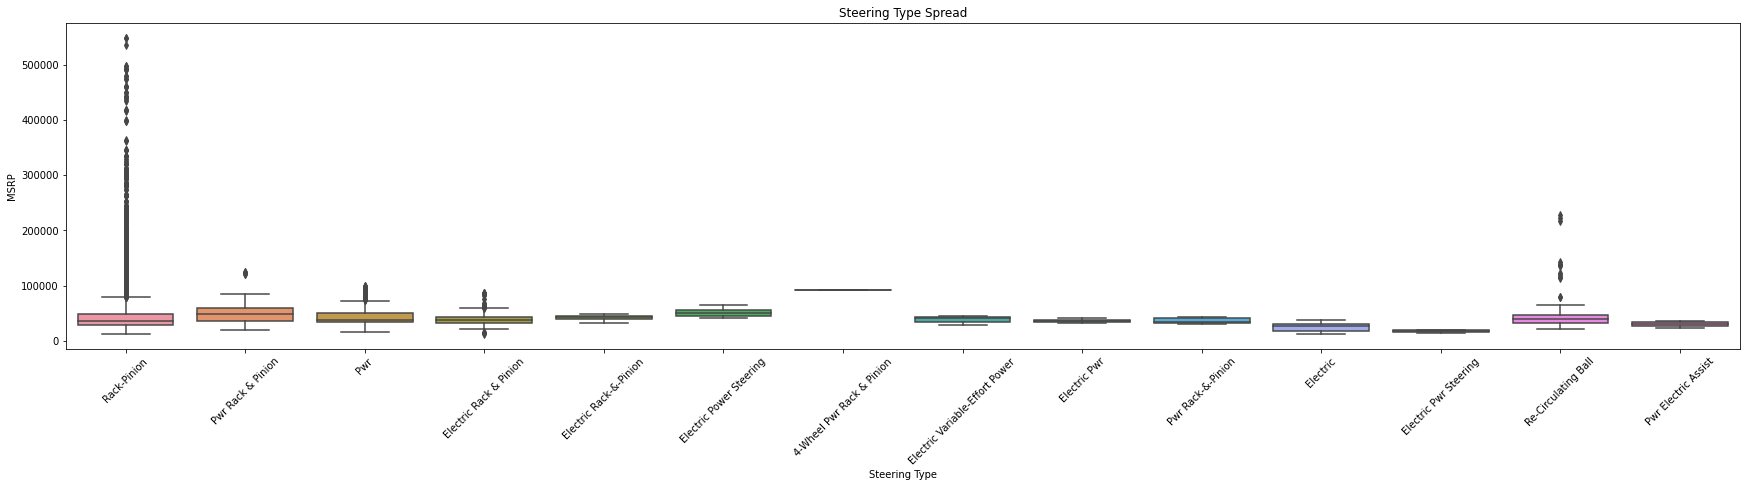

In [ ]:
plt.figure(figsize=(30,6))
plt.title('Steering Type Distribution')
sns.countplot(data=cars_cleaned, x='Steering Type', order=cars_cleaned['Steering Type'].value_counts().index)

plt.figure(figsize=(30,6))
plt.title('Steering Type Spread')
sns.boxplot(data=cars_cleaned, x='Steering Type', y='MSRP')
plt.xticks(rotation=45)

4-Wheel Pwr Rack & Pinion has the highest average MSRP, whereas Electric Pwr Steering has the lowest. It's counts are too low for it to be affecting the average MSRP.

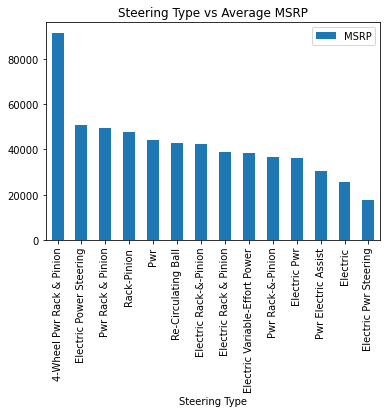

In [ ]:
df = pd.DataFrame(cars_cleaned.groupby(['Steering Type'])['MSRP'].mean().sort_values(ascending = False)) # groups cars by their steering type and shows the average MSRP for each type
df.plot.bar()
plt.title('Steering Type vs Average MSRP')
plt.show()

## Cars by Engine Configuration

V and I engine configurations are the most popular. From the box plot, it can be seen that the W engine configuration has the highest mean MSRP although it has very few cars.

From the box plot it can be observed that V and I engines are likely to affect the average MSRPs because of their counts and high number of outliers.

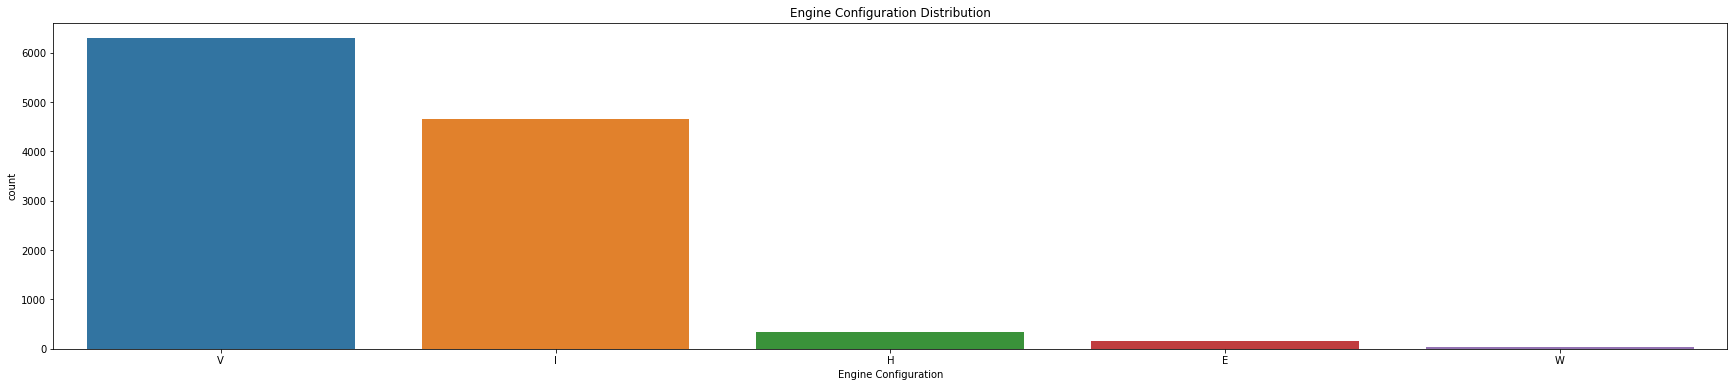

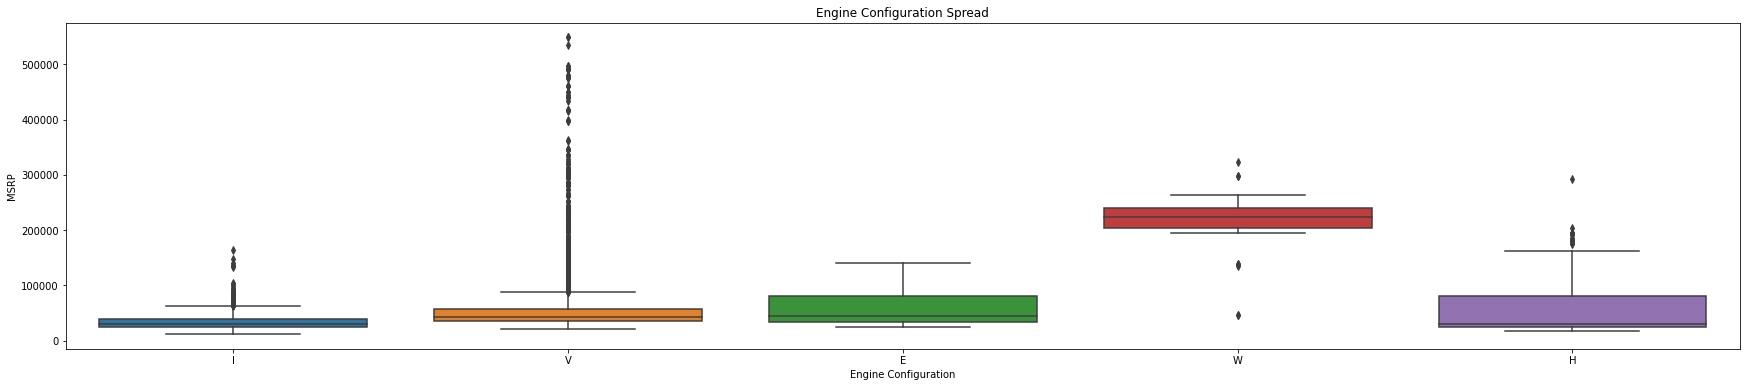

In [ ]:
plt.figure(figsize=(30,6))
plt.title('Engine Configuration Distribution')
sns.countplot(data=cars_cleaned, x='Engine Configuration', order=cars_cleaned['Engine Configuration'].value_counts().index)

plt.figure(figsize=(30,6))
plt.title('Engine Configuration Spread')
sns.boxplot(data=cars_cleaned, x='Engine Configuration', y='MSRP')

The W engine configuration has the highest average MSRP, whereas other engine configurations have comparable average MSRPs.

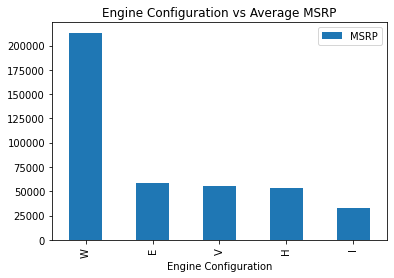

In [ ]:
df = pd.DataFrame(cars_cleaned.groupby(['Engine Configuration'])['MSRP'].mean().sort_values(ascending = False)) # groups cars by their steering type and shows the average MSRP for each type
df.plot.bar()
plt.title('Engine Configuration vs Average MSRP')
plt.show()

## Cars by EPA Classification

Mid-Size Cars are the most purchased and also have a high number of outliers. There is a sharp decrease from Mid-Size Cars to the rest of the categories.

From the box plots, we can consider Mid-Size and Compact cars to be affecting the average MSRPs because of their high counts and high number of outliers.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text major ticklabel objects>)

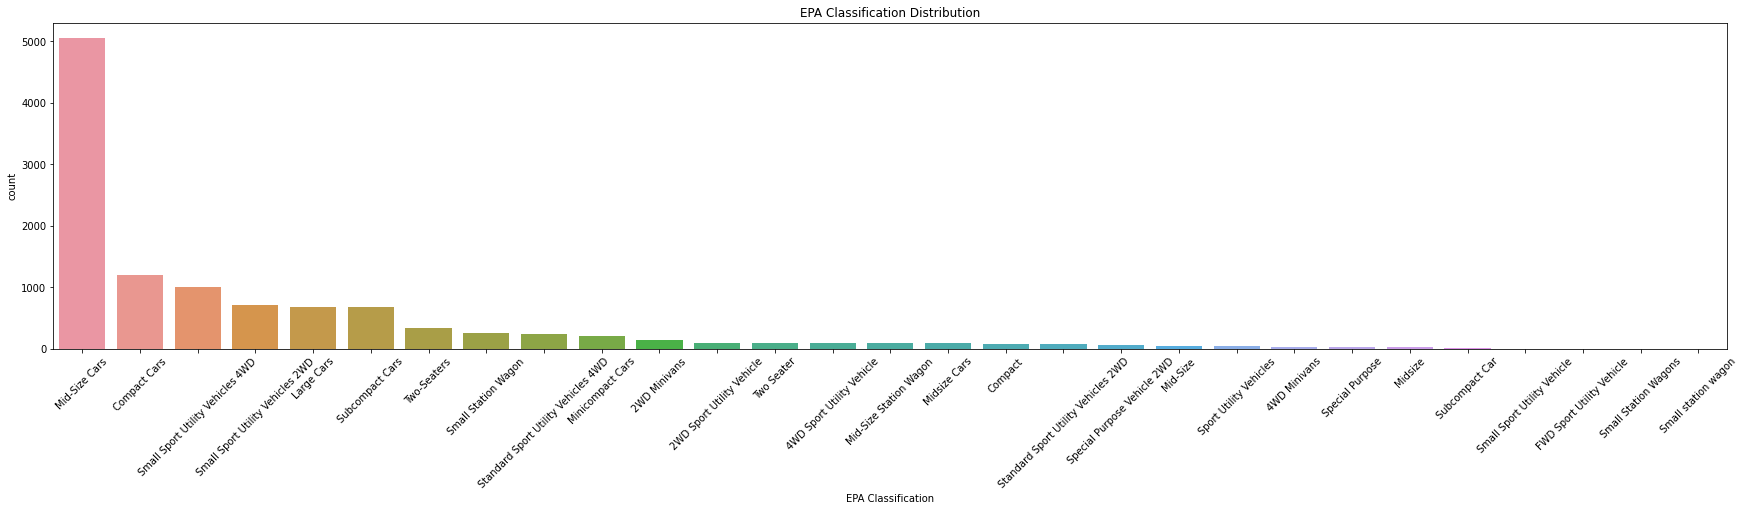

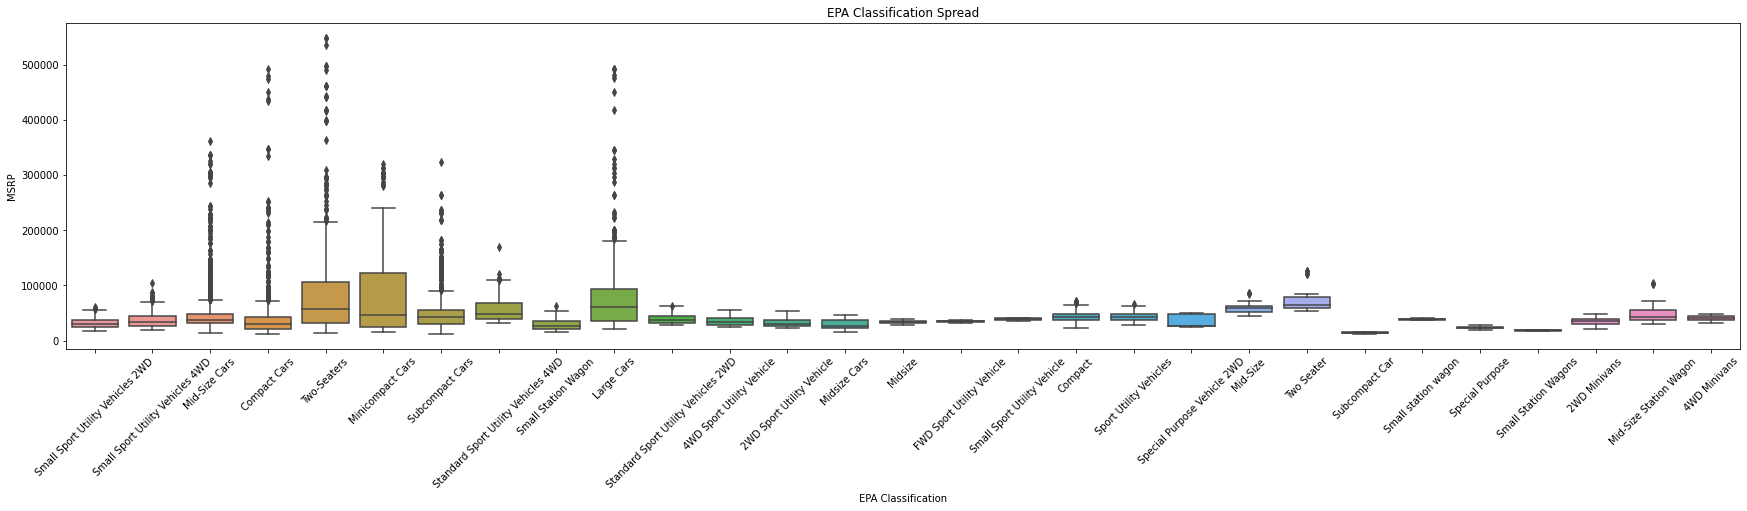

In [ ]:
plt.figure(figsize=(30,6))
plt.title('EPA Classification Distribution')
sns.countplot(data=cars_cleaned, x='EPA Classification', order=cars_cleaned['EPA Classification'].value_counts().index)
plt.xticks(rotation=45)

plt.figure(figsize=(30,6))
plt.title('EPA Classification Spread')
sns.boxplot(data=cars_cleaned, x='EPA Classification', y='MSRP')
plt.xticks(rotation=45)

Two-Seaters have the highest average MSRP, whereas subcompact cars have the lowest.

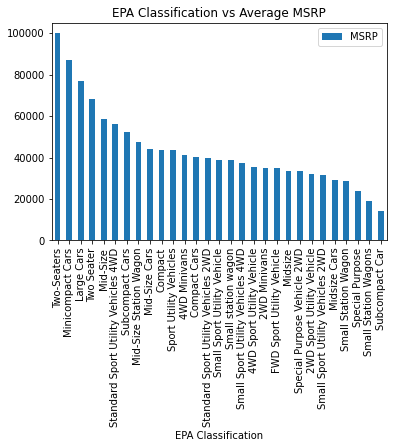

In [ ]:
df = pd.DataFrame(cars_cleaned.groupby(['EPA Classification'])['MSRP'].mean().sort_values(ascending = False)) # groups cars by their year of release and shows the average MSRP for each year
df.plot.bar()
plt.title('EPA Classification vs Average MSRP')
plt.show()

## Cars by Suspension Type - Front

Strut and Double Wishbone have the highest counts and a high number of outliers which means they could be affecting the average MSRP quite significantly.

The same could be said about Double Wishbone Pushrod because if it's high average MSRP but it does not have a lot of observations for it to be considered.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 <a list of 24 Text major ticklabel objects>)

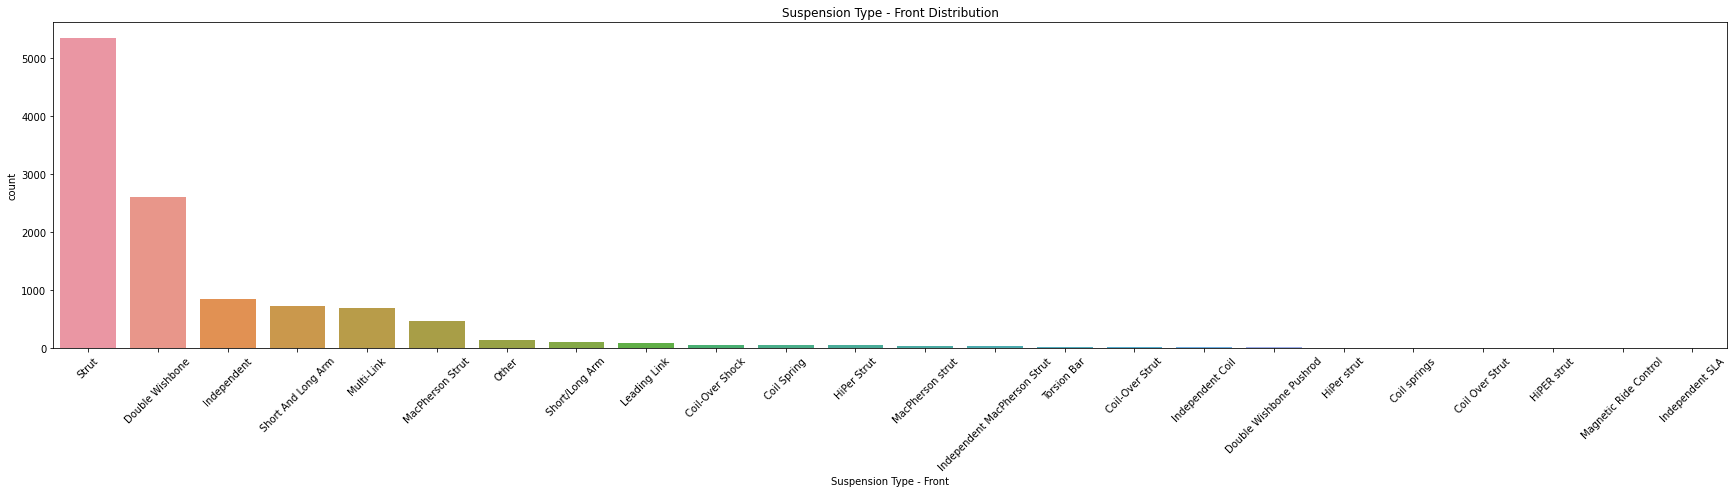

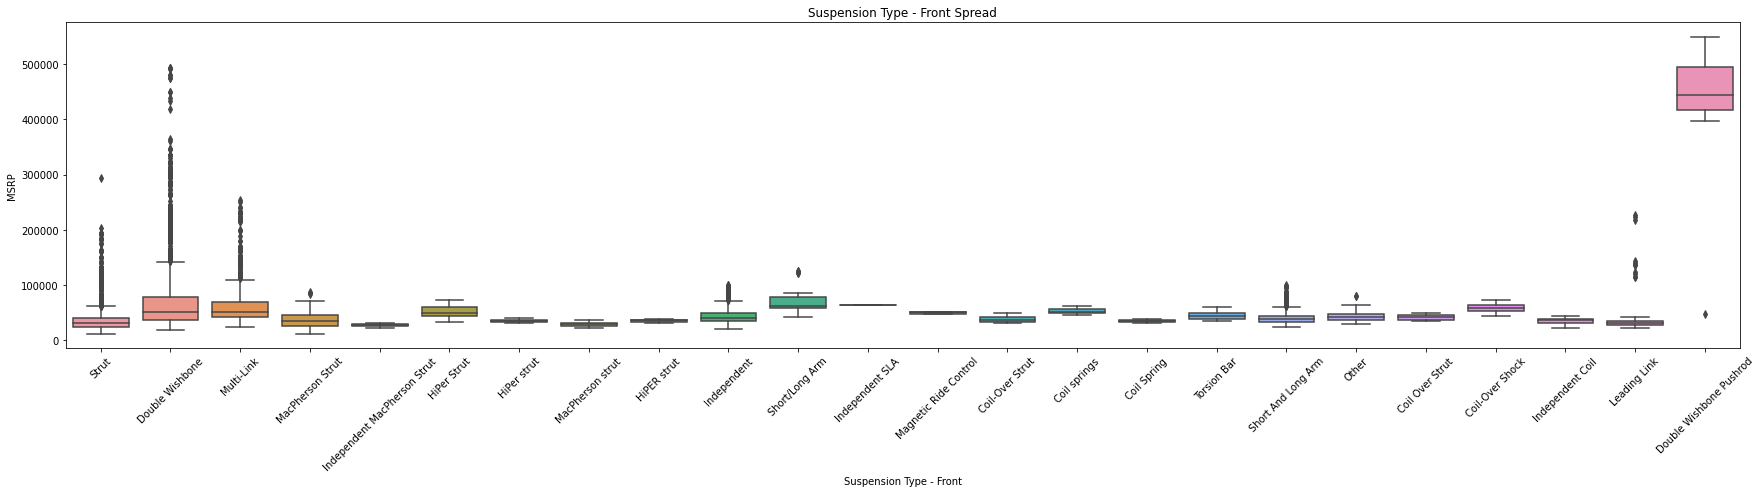

In [ ]:
plt.figure(figsize=(30,6))
plt.title('Suspension Type - Front Distribution')
sns.countplot(data=cars_cleaned, x='Suspension Type - Front', order=cars_cleaned['Suspension Type - Front'].value_counts().index)
plt.xticks(rotation=45)

plt.figure(figsize=(30,6))
plt.title('Suspension Type - Front Spread')
sns.boxplot(data=cars_cleaned, x='Suspension Type - Front', y='MSRP')
plt.xticks(rotation=45)
plt.xticks(rotation=45)

As observed, Double Wishbone Pushrod seems to skew the average MSRP quite a bit.

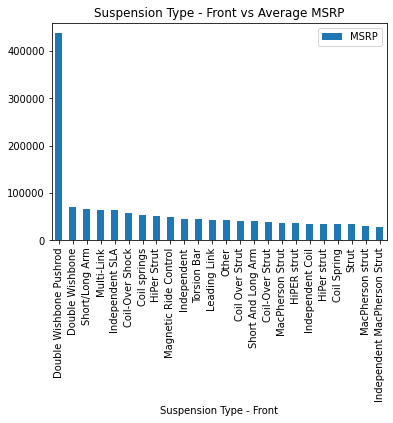

In [ ]:
df = pd.DataFrame(cars_cleaned.groupby(['Suspension Type - Front'])['MSRP'].mean().sort_values(ascending = False)) # groups cars by their year of release and shows the average MSRP for each year
df.plot.bar()
plt.title('Suspension Type - Front vs Average MSRP')
plt.show()

## Cars by Suspension Type - Rear

Multi-Link has the highest counts and a high number of outliers which means it could be affecting the average MSRP quite significantly.

The same could be said about Double Wishbone and Double Wishbone Pushrod because if it's high average MSRP but it does not have a lot of observations for it to be considered.

Leaf has the second highest counts but not a very large MSRP spread to be considered.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38]), <a list of 39 Text major ticklabel objects>)

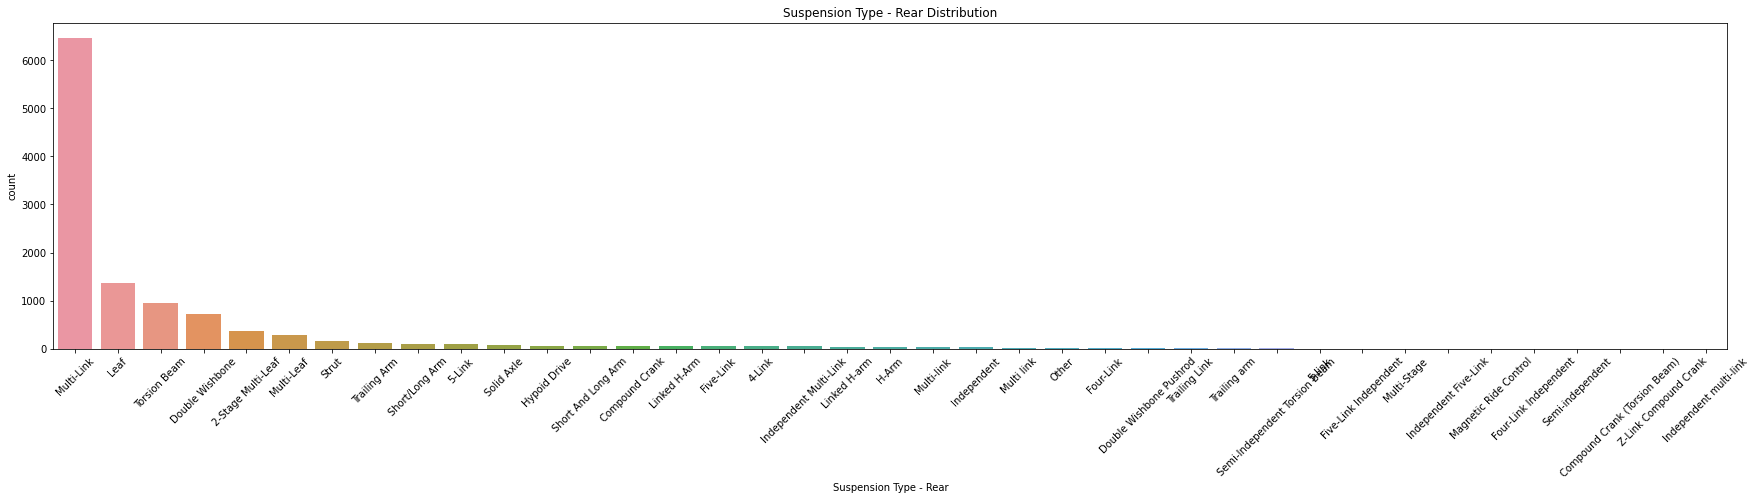

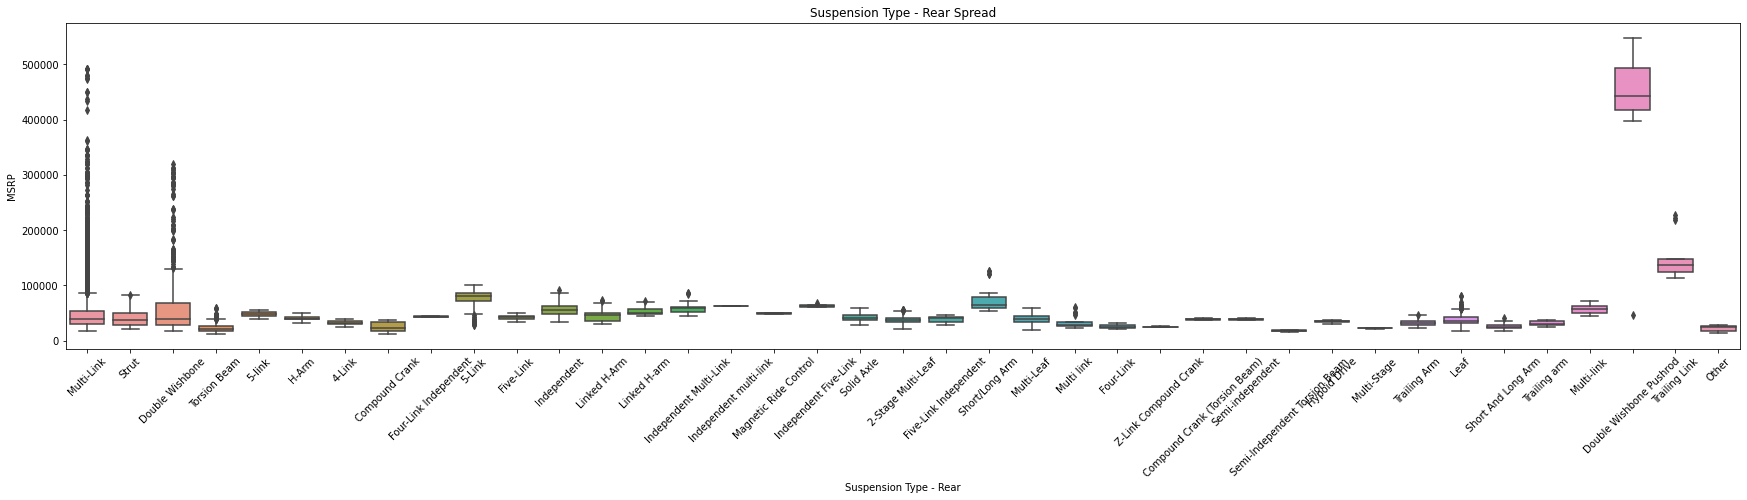

In [ ]:
plt.figure(figsize=(30,6))
plt.title('Suspension Type - Rear Distribution')
sns.countplot(data=cars_cleaned, x='Suspension Type - Rear', order=cars_cleaned['Suspension Type - Rear'].value_counts().index)
plt.xticks(rotation=45)

plt.figure(figsize=(30,6))
plt.title('Suspension Type - Rear Spread')
sns.boxplot(data=cars_cleaned, x='Suspension Type - Rear', y='MSRP')
plt.xticks(rotation=45)
plt.xticks(rotation=45)

As observed, Double Wishbone Pushrod seems to skew the average MSRP quite a bit.

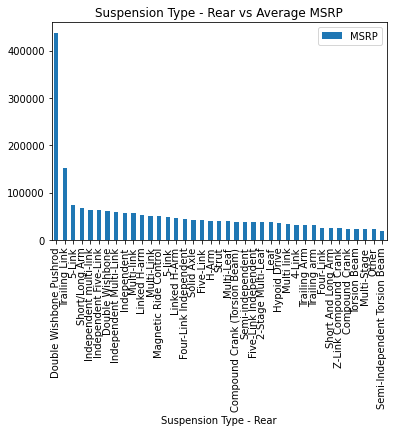

In [ ]:
df = pd.DataFrame(cars_cleaned.groupby(['Suspension Type - Rear'])['MSRP'].mean().sort_values(ascending = False)) # groups cars by their year of release and shows the average MSRP for each year
df.plot.bar()
plt.title('Suspension Type - Rear vs Average MSRP')
plt.show()

## Cars by Year

By looking at the plot, it is clear that older cars are less popular than the more recent ones. The year of release does not affect the average MSRP much, since there is no significant difference between the average MSRPs of the categories, and all of them have a high number of outliers.

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

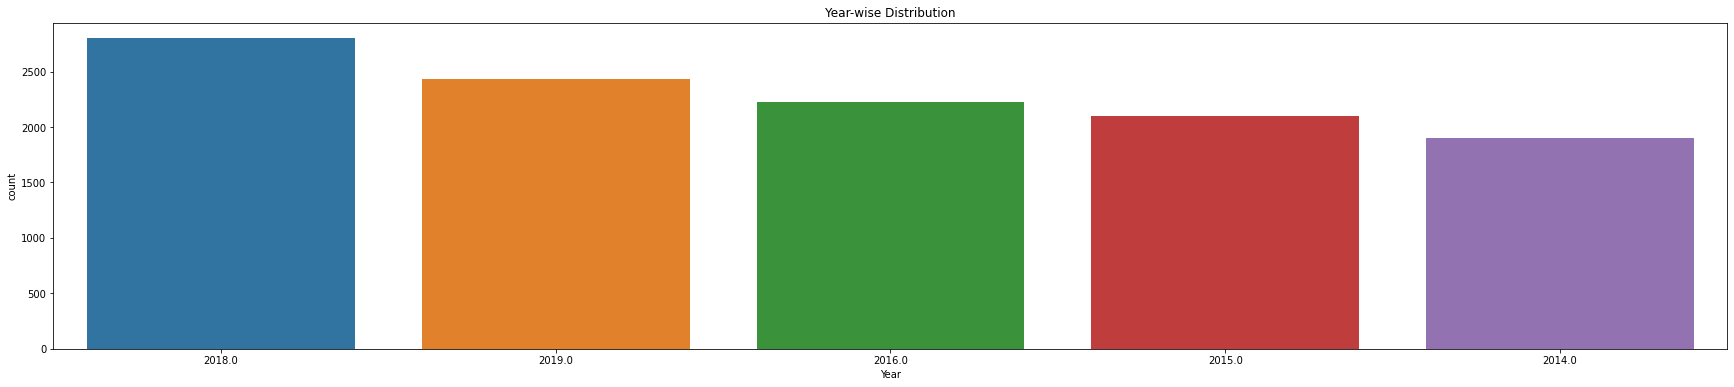

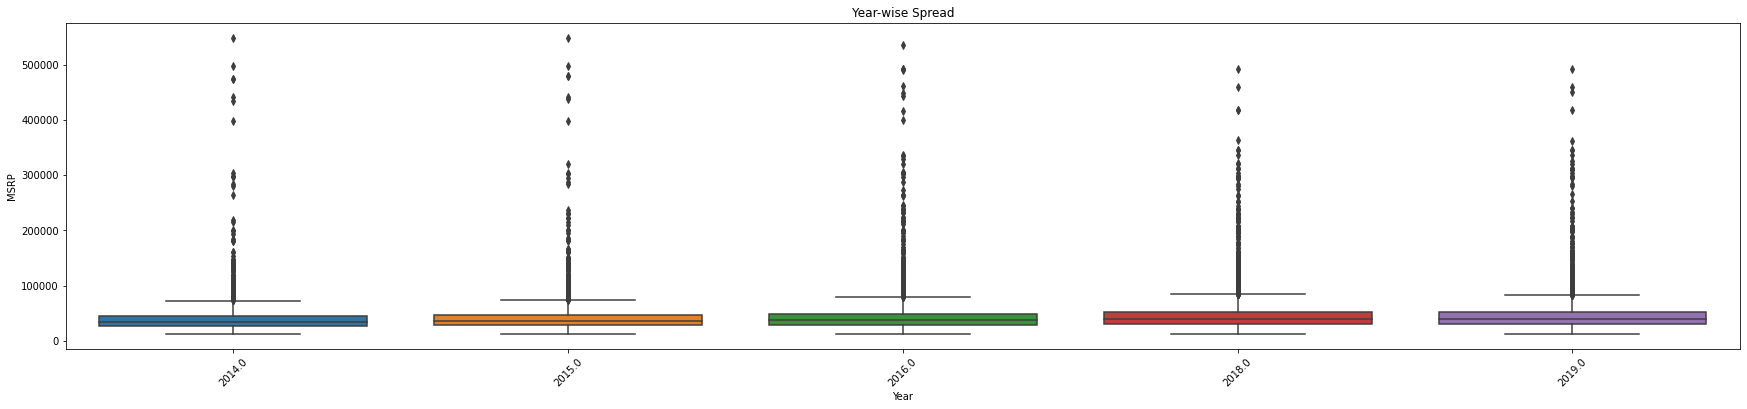

In [ ]:
plt.figure(figsize=(30,6))
plt.title('Year-wise Distribution')
sns.countplot(data=cars_cleaned, x='Year', order=cars_cleaned['Year'].value_counts().index)

plt.figure(figsize=(30,6))
plt.title('Year-wise Spread')
sns.boxplot(data=cars_cleaned, x='Year', y='MSRP')
plt.xticks(rotation=45)

More recently released cars are slightly more expensive. This is likely due to inflation over time.

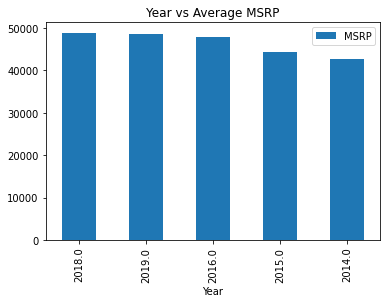

In [ ]:
df = pd.DataFrame(cars_cleaned.groupby(['Year'])['MSRP'].mean().sort_values(ascending = False)) # groups cars by their year of release and shows the average MSRP for each year
df.plot.bar()
plt.title('Year vs Average MSRP')
plt.show()

## Inferences

By now, we've established that these categorical features are likely to drive the MSRP.


*   Brand - Specifically high-end cars such as Lamborghini, Rolls-Royce and Bentley.

*   Fuel System - Gasoline Direct Injection, Sequential MPI and Direct Injection.

*   Body Style - Four-Door, Two-Door, Sports Utility, Convertible

*   Drivetrain - Rear Wheel Drive, All Wheel Drive and Four Wheel Drive cars.

*   Engine Class - Twin, Electric and Premium.

*   Steering Type - Rack-Pinion.

*   Engine Configuration - V and I.

*   EPA Classification - Mid-Size and Compact cars.

*   Suspension Type - Front - Strut and Double Wishbone.

*   Suspension Type - Rear - Multi-Link.












# Visual Analysis of Numerical Features

Based on the results from the correlation heatmap below, I have visualised the numerical features with the highest positive and negative correlations as scatter plots with the feature on the x-axis and the MSRP on the y-axis. 

## Correlation Heatmap

Here, I have created a correlation heatmap showing how each pair of features is linearly related. A darker (bluer) colour means the pair of features have a positive correlation, whereas a lighter (more yellow) colour represents a negative correlation.

It is evident from the heatmap that Net Horsepower, Net Torque, Tire Width Ratio, Base Curb Weight (lbs) and Basic Miles/km are have the highest positive correlation with the MSRP. As the value of these features increases, so does the MSRP.

On the contrary, Tire Ratio, Fuel Economy Est-Combined (MPG), EPA Fuel Economy Est - City (MPG) and EPA Fuel Economy Est - Hwy (MPG) have the highest negative correlation with the MSRP. As the value of these features increases, the MSRP decreases.

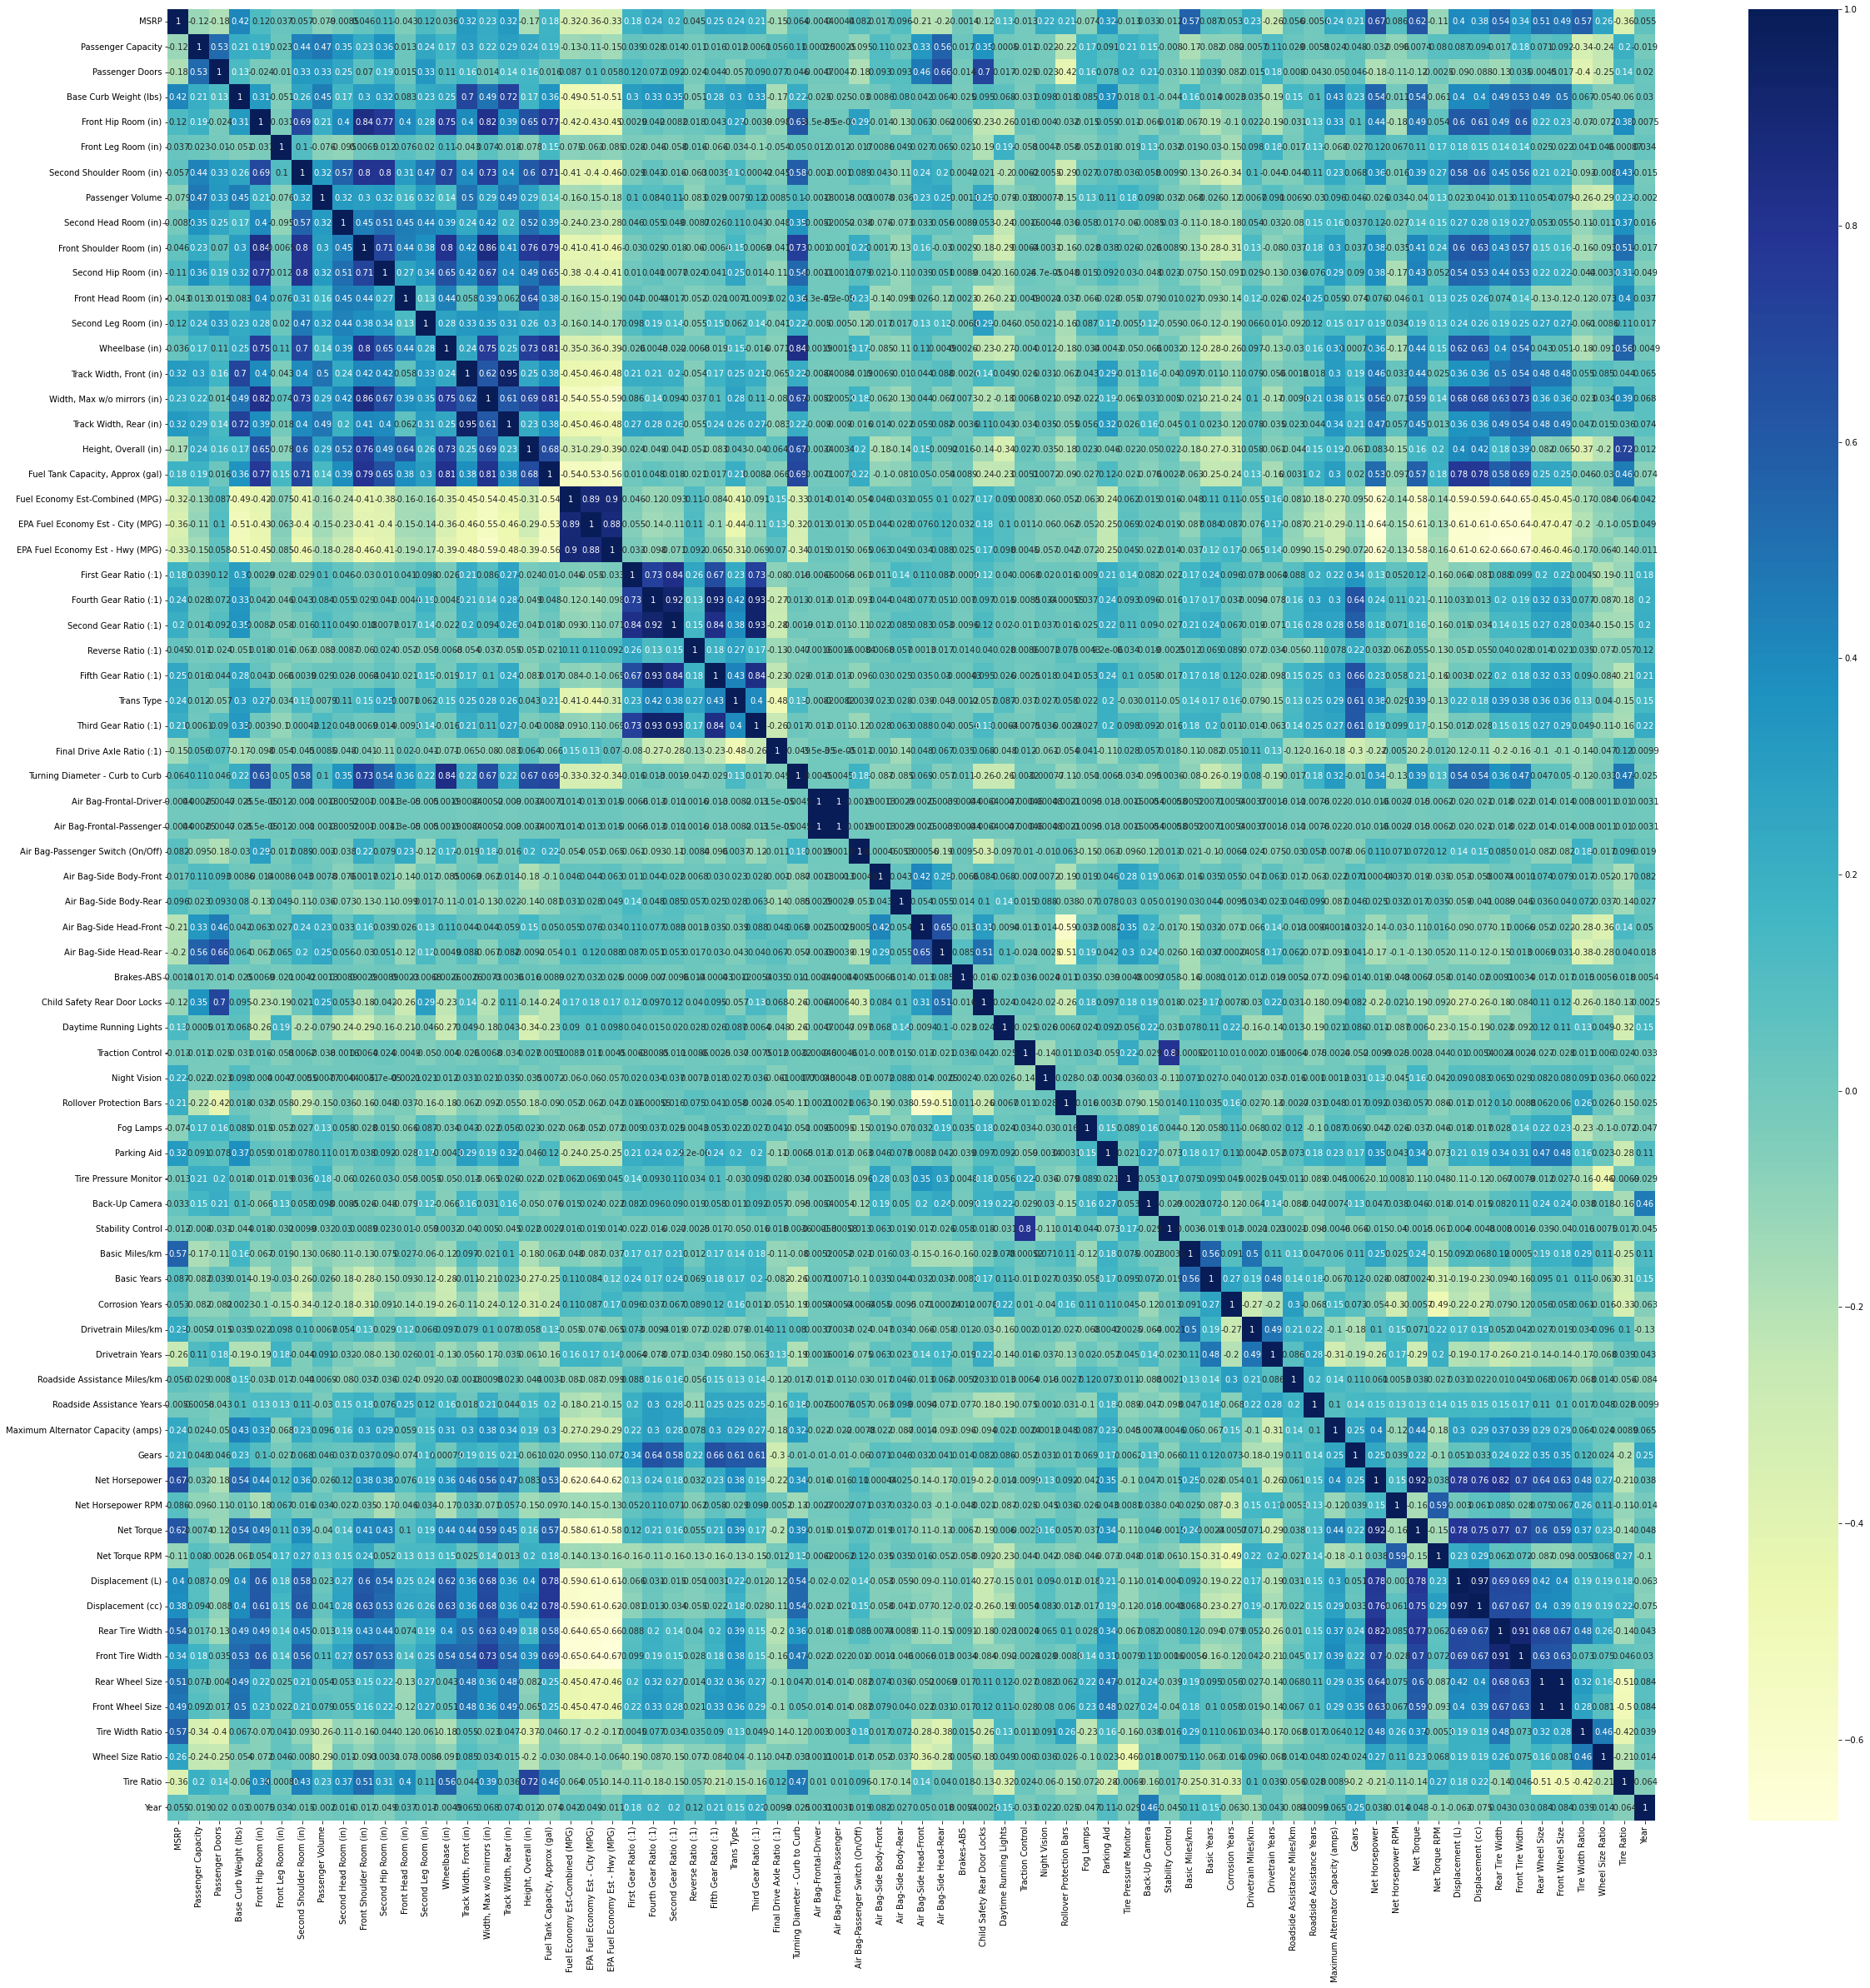

In [ ]:
plt.figure(figsize = (40, 40))
sns.heatmap(cars_cleaned.corr(), cmap="YlGnBu", annot=True) #plots a correlation heatmap for the numerical car data

The first row or first column of this correlation heatmap gives the correlation of each feature with the MSRP.

## Inferences

From the correlation heatmap, we've established that these numerical features are likely to drive the MSRP.


*   Net Horsepower

*   Net Torque

*   Tire Ratio

*   Tire Width Ratio

*   Base Curb Weight (lbs)

*   EPA Fuel Economy Est - City (MPG)

*   EPA Fuel Economy Est - Hwy (MPG)

*   Fuel Economy Est-Combined (MPG)




## Net Horsepower vs Average MSRP

The general trend in this plot shows that cars with more Net Horsepower are more expensive and hence Net Torque has a strong positive correlation with the MSRP.

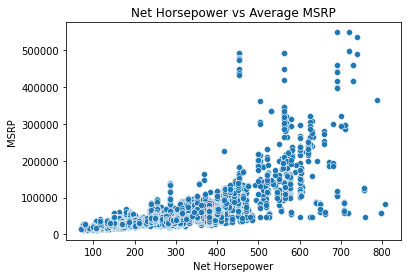

In [ ]:
sns.scatterplot(data=cars_cleaned, x='Net Horsepower', y='MSRP')
plt.title('Net Horsepower vs Average MSRP')
plt.show()

## Net Torque vs Average MSRP

The general trend in this plot shows that cars with more Net Torque are more expensive and hence Net Torque has a strong positive correlation with the MSRP.

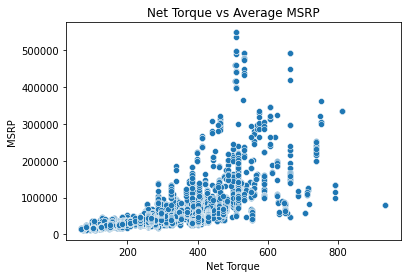

In [ ]:
sns.scatterplot(data=cars_cleaned, x='Net Torque', y='MSRP')
plt.title('Net Torque vs Average MSRP')
plt.show()

## Tire Width Ratio vs Average MSRP

The Tire Width Ratio seems to have a slightly positive correlation with the MSRP. Cars with higher tire width ratios generally have higher MSRPs.

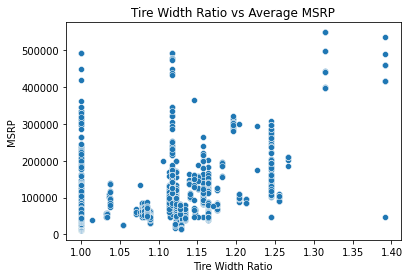

In [ ]:
sns.scatterplot(data=cars_cleaned, x='Tire Width Ratio', y='MSRP')
plt.title('Tire Width Ratio vs Average MSRP')
plt.show()

## Base Curb Weight (lbs) vs Average MSRP

The Base Curb Weight has a slight positive correlation with the MSRP.

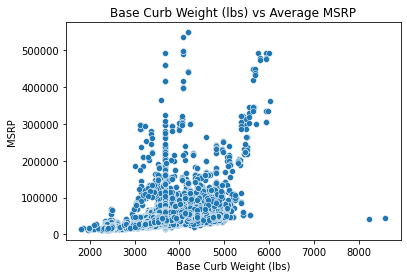

In [ ]:
sns.scatterplot(data=cars_cleaned, x='Base Curb Weight (lbs)', y='MSRP')
plt.title('Base Curb Weight (lbs) vs Average MSRP')
plt.show()

## Tire Ratio vs Average MSRP

Cars with a Tire Ratio higher than 5 have a considerably average MSRP as compared to the rest. Tire Ratio has a negative correlation with the MSRP.

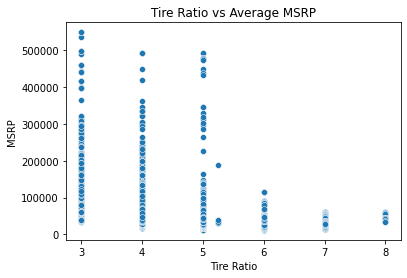

In [ ]:
sns.scatterplot(data=cars_cleaned, x='Tire Ratio', y='MSRP')
plt.title('Tire Ratio vs Average MSRP')
plt.show()

## EPA Fuel Economy Est - City (MPG) vs Average MSRP

The plot indicates a negative correlation where cars with a lower MPG have a higher MSRP. 

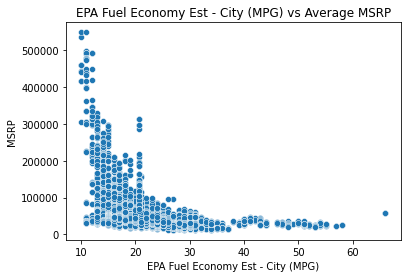

In [ ]:
sns.scatterplot(data=cars_cleaned, x='EPA Fuel Economy Est - City (MPG)', y='MSRP')
plt.title('EPA Fuel Economy Est - City (MPG) vs Average MSRP')
plt.show()

## EPA Fuel Economy Est - Hwy (MPG) vs Average MSRP

The plot indicates a negative correlation where cars with a lower MPG have a higher MSRP. 

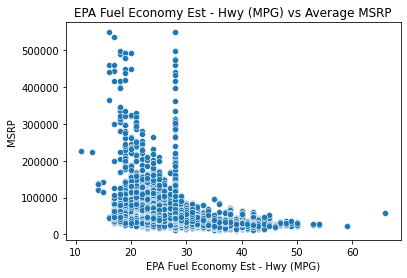

In [ ]:
sns.scatterplot(data=cars_cleaned, x='EPA Fuel Economy Est - Hwy (MPG)', y='MSRP')
plt.title('EPA Fuel Economy Est - Hwy (MPG) vs Average MSRP')
plt.show()

## Fuel Economy Est-Combined (MPG) vs Average MSRP

The plot indicates a negative correlation where cars with a lower MPG have a higher MSRP. 

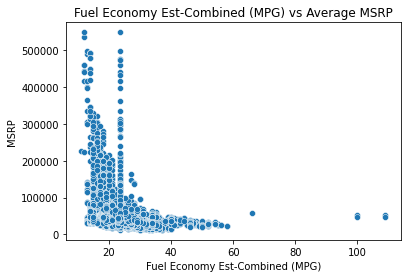

In [ ]:
sns.scatterplot(data=cars_cleaned, x='Fuel Economy Est-Combined (MPG)', y='MSRP')
plt.title('Fuel Economy Est-Combined (MPG) vs Average MSRP')
plt.show()

# Recursive Feature Elimination

In this section, I have used recursive feature elimination to get the top 10 features among the features selected after the visual analysis with linear regression as the estimator.

## Creating New Features

This section creates a separate dataframe containing the features selected after the visual analysis. I have used dummy variable encoding to represent the categorical features as numerical features. There are 33 features in total including the MSRP.

In [ ]:
cars_num = cars_cleaned[['MSRP', 'Net Horsepower', 'Net Torque', 
                         'Tire Width Ratio', 'Tire Ratio', 'EPA Fuel Economy Est - City (MPG)',
                         'EPA Fuel Economy Est - Hwy (MPG)', 'Fuel Economy Est-Combined (MPG)', 'Base Curb Weight (lbs)']].copy() # numerical features from visual analysis 

cars_cat = pd.get_dummies(cars_cleaned[['Make', 'Fuel System', 'Body Style',
                         'Drivetrain', 'Engine Class', 'Steering Type',
                         'Engine Configuration', 'EPA Classification', 'Suspension Type - Front',
                         'Suspension Type - Rear']]).copy() # categorical features from visual analysis      

cars_rfe = pd.concat([cars_num, cars_cat[['Make_Lamborghini', 'Make_Rolls-Royce', 'Make_Bentley',
                                          'Fuel System_Gasoline Direct Injection', 'Fuel System_Sequential MPI', 'Fuel System_Direct Injection',
                                          'Body Style_4dr Car', 'Body Style_2dr Car', 'Body Style_Sport Utility', 'Body Style_Convertible', 
                                          'Drivetrain_Rear Wheel Drive', 'Drivetrain_All Wheel Drive', 'Drivetrain_Four Wheel Drive', 
                                          'Engine Class_Twin', 'Engine Class_Electric', 'Engine Class_Premium',
                                          'Steering Type_Rack-Pinion',
                                          'Engine Configuration_V', 'Engine Configuration_I',
                                          'EPA Classification_Mid-Size', 'EPA Classification_Compact',
                                          'Suspension Type - Front_Strut', 'Suspension Type - Front_Double Wishbone',
                                          'Suspension Type - Rear_Multi-Link']]], axis=1) # combined dataframe            

cars_rfe.shape             


(11457, 33)

## Scaling

This section uses the MinMaxScaler to normalise the input features.

In [ ]:
scaler = MinMaxScaler() # min-max scaler from the sklearn library that scales independent variables such that they lie between 0 and 1
cars_rfe[:] = scaler.fit_transform(cars_rfe) # fits the scaler on the dataset and outputs a new one that is scaled

In [ ]:
cars_rfe.head()

MSRP  Net Horsepower  Net Torque  Tire Width Ratio  Tire Ratio  \
0  0.053296        0.273713    0.244521               0.0         0.4   
1  0.062424        0.273713    0.244521               0.0         0.4   
2  0.058885        0.273713    0.244521               0.0         0.2   
3  0.047335        0.273713    0.244521               0.0         0.4   
4  0.057022        0.273713    0.244521               0.0         0.4   

   EPA Fuel Economy Est - City (MPG)  EPA Fuel Economy Est - Hwy (MPG)  \
0                           0.214286                          0.309091   
1                           0.214286                          0.309091   
2                           0.214286                          0.290909   
3                           0.214286                          0.309091   
4                           0.196429                          0.290909   

   Fuel Economy Est-Combined (MPG)  Base Curb Weight (lbs)  Make_Lamborghini  \
0                         0.132653                0.292201               0.0   
1                         0.132653                0.297951               0.0   
2                         0.132653                0.296771               0.0   
3                         0.132653                0.291169               0.0   
4                         0.122449                0.326994               0.0   

   ...  Engine Class_Electric  Engine Class_Premium  \
0  ...                    0.0                   0.0   
1  ...                    0.0                   0.0   
2  ...                    0.0                   0.0   
3  ...                    0.0                   0.0   
4  ...                    0.0                   0.0   

   Steering Type_Rack-Pinion  Engine Configuration_V  Engine Configuration_I  \
0                        1.0                     0.0                     1.0   
1                        1.0                     0.0                     1.0   
2                        1.0                     0.0                     1.0   
3                        1.0                     0.0                     1.0   
4                        1.0                     0.0                     1.0   

   EPA Classification_Mid-Size  EPA Classification_Compact  \
0                          0.0                         0.0   
1                          0.0                         0.0   
2                          0.0                         0.0   
3                          0.0                         0.0   
4                          0.0                         0.0   

   Suspension Type - Front_Strut  Suspension Type - Front_Double Wishbone  \
0                            1.0                                      0.0   
1                            1.0                                      0.0   
2                            1.0                                      0.0   
3                            1.0                                      0.0   
4                            1.0                                      0.0   

   Suspension Type - Rear_Multi-Link  
0                                1.0  
1                                1.0  
2                                1.0  
3                                1.0  
4                                1.0  

[5 rows x 33 columns]

## Training

The linear regression model is trained on the input features, followed by the recursive feature elimination model.

In [ ]:
Y = cars_rfe.pop('MSRP') # removes the target feature (MSRP) from the dataset and stores it in another dataframe 
X = cars_rfe # these are the features that will be used to train the linear regression model
x_cars_train, x_cars_test, y_cars_train, y_cars_test = train_test_split(X, Y, train_size=0.7, test_size=0.3, random_state=100) # uses the train_test_split function from the sklearn feature selection to split the dataset into a training and test set with randomisation

In [ ]:
lr = LinearRegression() # initialises the linear regression model
lr.fit(x_cars_train, y_cars_train) # fits a linear regression model to the training data
rfe = RFE(lr, n_features_to_select=14) # initialises the recursive feature elimination model with linear regression as the estimator and 10 features to select
rfe = rfe.fit(x_cars_train, y_cars_train) # fits the recursive feature elimination model on the training data

## Results

As seen from the code cell below, these are the top 10 features extracted by the RFE model (I am treating the different Makes and Engine Classes as one feature each).

In [ ]:
for item in list(x_cars_train.columns[rfe.support_]):
  print(item)

Net Horsepower
Net Torque
Tire Width Ratio
Tire Ratio
EPA Fuel Economy Est - City (MPG)
Base Curb Weight (lbs)
Make_Lamborghini
Make_Rolls-Royce
Make_Bentley
Body Style_2dr Car
Engine Class_Twin
Engine Class_Electric
Engine Configuration_V
EPA Classification_Compact


Upon testing the linear regression model on the test set, we get an R-squared value of 80.2%. 

In [ ]:
y_pred = lr.predict(x_cars_test) # predict MSRP using the linear regression model
r2 = r2_score(y_cars_test, y_pred) # find the r2 score using ground truth and predicted values
r2*100

80.25584608044238